In [33]:
#-------machine learning-------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from keras.callbacks import ModelCheckpoint, CSVLogger
#-------other packages-------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re
import os
import csv
import math
import time
from scipy.stats import norm
print('Packages imported...')

Packages imported...


In [34]:
observer_angle = 0
target_b = 0.0
#target_b = 0.25
#target_lambda = 0.0
#target_lambda = 0.7854
target_lambda = 1.5708
target_vel = 25.0
target_b_str = str(target_b).replace('.', '_')
target_lambda_str = str(target_lambda).replace('.', '_')
target_vel_str = str(target_vel).replace('.', '_')

# Analyze folder contents and make velocity prediction for test data generation

In [35]:
which_class = "noise"
mc_value = 600000
training_profiles_to_generate = 1500 # number of training profiles to generate for training location regression models
train_frac = 0.8                     # fraction of profiles used to train over fraction of profiles used to test the location regression models
number_of_models = 125               # specify the number of location regression models you want to train

In [36]:
# location of base directories
mod_dir = '/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/Velocity_Regression_Model' #directory for models
if which_class == "clean":
    classifier_dir = f'{mod_dir}/Classifier_Models/Clean'
elif which_class == "noise":
    classifier_dir = f'{mod_dir}/Classifier_Models/Noise'

working_dir = f'/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/{observer_angle}_deg/{target_vel_str}'

files = os.listdir(working_dir)
print(f"Processing folder: {working_dir}")
print('')
print("Files in folder:")
for file in files:
    print(file)

Processing folder: /projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/0_deg/25_0

Files in folder:
25_0_km_s_0_0_rad_0_0_b_6_pts_noise_oots_profiles.npy
25_0_km_s_0_0_rad_0_0_b_6_pts_clean_raw_profiles.npy
25_0_km_s_0_0_rad_0_0_b_6_pts_clean_oot_profile.npy
25_0_km_s_0_0_rad_0_0_b_6_pts_noise_raw_profiles.npy
25_0_km_s_0_0_rad_0_0_b_6_pts_noise_oot_profile.npy
25_0_km_s_0_0_rad_0_0_b_6_pts_coordinates.npy
25_0_km_s_0_0_rad_0_25_b_6_pts_noise_oot_profile.npy
25_0_km_s_0_0_rad_0_25_b_6_pts_noise_oots_profiles.npy
25_0_km_s_0_0_rad_0_25_b_6_pts_noise_raw_profiles.npy
25_0_km_s_0_0_rad_0_25_b_6_pts_clean_oot_profile.npy
25_0_km_s_0_0_rad_0_25_b_6_pts_clean_raw_profiles.npy
25_0_km_s_0_0_rad_0_25_b_6_pts_coordinates.npy
25_0_km_s_0_7854_rad_0_0_b_6_pts_noise_oot_profile.npy
25_0_km_s_0_7854_rad_0_0_b_6_pts_noise_oots_profiles.npy
25_0_km_s_0_7854_rad_0_0_b_6_pts_noise_raw_profiles.npy
25_0_km_s_0_7854_rad_0_0_b_6_pts_clean_oot_profile.npy
25_0_km_s_0_7854_rad_0_0_b_6_pts_clean_

In [37]:
raw_profiles_path = f"{working_dir}/{target_vel_str}_km_s_{target_lambda_str}_rad_{target_b_str}_b_6_pts_noise_raw_profiles.npy"
oot_profile_path = f"{working_dir}/{target_vel_str}_km_s_{target_lambda_str}_rad_{target_b_str}_b_6_pts_noise_oot_profile.npy"
oot_sub_profiles_path = f"{working_dir}/{target_vel_str}_km_s_{target_lambda_str}_rad_{target_b_str}_b_6_pts_noise_oots_profiles.npy"

# How the general model is designed to run
#raw_profiles_path = f"{working_dir}/raw_profiles.npy"
#oot_profile_path = f"{working_dir}/oot_profile.npy"
#oot_sub_profiles_path = f"{working_dir}/oot_sub_profiles.npy"

raw_profiles = np.load(raw_profiles_path)
oot_profile = np.load(oot_profile_path)

if os.path.exists(raw_profiles_path) and os.path.exists(oot_profile_path) and os.path.exists(oot_sub_profiles_path):
    oot_sub_profiles = np.load(oot_sub_profiles_path)
    print("Out-of-transit-subtracted profiles already exist...")
elif os.path.exists(raw_profiles_path) and os.path.exists(oot_profile_path):
    # Subtract oot_profile from raw_profiles
    oot_sub_profiles = raw_profiles - np.tile(oot_profile, (raw_profiles.shape[0], 1))
    # Save the result in the same folder
    np.save(oot_sub_profiles_path, oot_sub_profiles)
    print(f"Out-of-transit profiles processed and saved as: {oot_sub_profiles_path}")

Out-of-transit-subtracted profiles already exist...


In [38]:
classifier_model = keras.models.load_model(classifier_dir)
print(f'Poceeding with {which_class} classifier model...')
print('')

# Check if the .npy file exists in the folder
if os.path.isfile(oot_profile_path):
    # Use the classifier model to make predictions on the oot profile; reshape predictions
    velocity_prediction = classifier_model.predict(np.expand_dims(oot_profile, axis=0))[0][0]
    # Print the predictions and folder name
    print(f"Classifier prediction: {velocity_prediction:.4f} km/s")

Poceeding with noise classifier model...

Classifier prediction: 25.1140 km/s


# Generate network training data profiles based on analysis of classifier prediction

In [39]:
# basic array sum definition
def sum_array(arr):
    sum = 0
    for i in arr:
        sum += i
    return sum

def create_sub_folder(directory, folder_name):
    folder_path = os.path.join(directory, folder_name)
    # Check if the folder exists, and if not, create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_name}' created in '{directory}'.")
    else:
        print(f"Folder '{folder_name}' already exists in '{directory}'.")

In [40]:
#if observer_angle != 0:
#    observer_angle_rad = math.radians(observer_angle)
#    sin_observer_angle = math.sin(observer_angle_rad)
#    vel_eq = velocity_prediction / sin_observer_angle
#else:
#    vel_eq = velocity_prediction
#print(f'velocity: {velocity_prediction}')
#print(f'adjusted velocity: {vel_eq}')

if observer_angle != 0:
    observer_angle_rad = math.radians(observer_angle)
    sin_observer_angle = math.sin(observer_angle_rad)
    vel_eq = target_vel / sin_observer_angle
else:
    vel_eq = target_vel
print(f'velocity: {target_vel}')
print(f'adjusted velocity: {vel_eq}')

velocity: 25.0
adjusted velocity: 25.0


In [41]:
# generate training data for specialized machine learning model

nVelocity = 401
minx = -100
maxx = 100

# Check if the directory exists, and if not, create it
create_sub_folder(working_dir, "prediction_model")
prediction_dir = f"{working_dir}/prediction_model"
training_files_clean = ['training_coordinates.npy', 'training_raw_profiles.npy', 'training_oot_profile.npy', 'training_oot_sub_profiles.npy']
training_files_noise = ['training_raw_noise_profiles.npy', 'training_oot_noise_profile.npy', 'training_oot_sub_noise_profiles.npy']

# Check if the numpy files exist in the folder
for file_name in training_files_clean:
    file_path = os.path.join(prediction_dir, file_name)
    if not os.path.exists(file_path):
        # If the file doesn't exist, create an empty numpy file
        np.save(file_path, np.array([]))

Folder 'prediction_model' already exists in '/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/0_deg/25_0'.


In [42]:
# definition of the gaussian profile
def gaussian_fct(x, amp, cen, sigma):
    return amp*(np.exp((-1.0/2.0)*(((x-cen)/sigma)**2)))

# velocity shift
def shift_profile_velocity(x, y, velocity):
    shift = velocity
    xshifted = x + shift
    yshifted = np.interp(x, xshifted, y)
    return yshifted

# limb darkening
def limb_dark(eps,radius):
    ld = 1.0 - eps + eps*np.cos(np.arcsin(radius))
    return ld

# projected rotational velocity
def proj_vel(vel_eq, x_comp, observer_angle):
    pv = vel_eq * x_comp * np.cos(np.radians(observer_angle))
    return pv

# mc integration
def mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, n_mc):
    r_s, r_p = 1.0, 0.156
    x_p, y_p = x_p, y_p
    vel_eq, eps = vel_eq, 0.7
    n_mc = n_mc
    r_act = r_s

    amplitude = 0.9
    center = 0.0
    sigma = 5.0

    n_out = 0
    checkflux1 = 0.0
    checkflux2 = 0.0

    velocityArray = np.linspace(minx,maxx,nVelocity)
    flux_profile = np.zeros([nVelocity])
    flux = 0.0
    int_profile = gaussian_fct(velocityArray, amplitude, center, sigma)

    x_array_mc = np.zeros([n_mc])
    y_array_mc = np.zeros([n_mc])
    r_array_mc = np.zeros([n_mc])

    # Vectorized version
    theta_mc = np.random.uniform(0, 2.*np.pi, n_mc)
    r_mc = np.random.uniform(0, r_act, n_mc)

    for i in range(n_mc):

        x_mc = np.sqrt(r_mc[i]) * np.cos(theta_mc[i])
        y_mc = np.sqrt(r_mc[i]) * np.sin(theta_mc[i])
        check_planet = (np.abs(x_mc-x_p))**2 + (np.abs(y_mc-y_p)**2) > r_p**2

        if check_planet:
            x_array_mc[i] = x_mc
            y_array_mc[i] = y_mc
            r_array_mc[i] = np.sqrt(x_mc**2 + y_mc**2)
            pv = proj_vel(vel_eq,x_mc,observer_angle)
            ld = limb_dark(eps,r_array_mc[i])
            local_profile = shift_profile_velocity(velocityArray, int_profile, pv)
            local_profile = local_profile * ld
            flux_profile = flux_profile + local_profile
            flux = flux + ld
            n_out = n_out + 1

    flux = flux*(r_s**2)/(r_act**2)
    flux_profile = flux_profile/flux
    flux_profile = flux_profile.reshape(-1, nVelocity)

    return flux_profile, flux

In [43]:
if os.path.exists(f"{prediction_dir}"):
    if len(os.listdir(f"{prediction_dir}")) <= 4:
        simulate_start_time = time.time()
        # Initialize empty lists
        coordinates_list = []
        intensities_list = []
        # mc routine
        r_p = np.sqrt(np.random.uniform(0, 1.0, training_profiles_to_generate))
        theta_p = np.random.uniform(0, np.pi, training_profiles_to_generate)
        mc_value = mc_value
        for i in range(training_profiles_to_generate):
            x_p = r_p[i] * np.cos(theta_p[i])
            y_p = r_p[i] * np.sin(theta_p[i])
            try:
                flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, mc_value)
                flux_profile = 1.0 - flux_profile
                # Append new data to the lists
                coordinates_list.append([x_p, y_p])
                intensities_list.append(flux_profile)
            except Exception as e:
                print(f"Error while processing profile {i}: {str(e)}")
        # Convert the lists to numpy arrays
        coordinates_array = np.array(coordinates_list)
        intensities_array = np.squeeze(np.array(intensities_list), axis=1)
        # Save the updated arrays as numpy files
        np.save(f"{prediction_dir}/{training_files_clean[0]}", coordinates_array)
        np.save(f"{prediction_dir}/{training_files_clean[1]}", intensities_array)
        # oot profile generation
        x_p = 5
        y_p = 5
        try:
            flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, mc_value)
            oot_flux_profile = 1.0 - flux_profile
            oot_flux_profile = oot_flux_profile.flatten()
        except Exception as e:
            print(f"Error while processing profile: {str(e)}")
        # Save the updated array as a numpy file
        np.save(f"{prediction_dir}/{training_files_clean[2]}", oot_flux_profile)
        simulate_end_time = time.time()
        simulate_time = simulate_end_time-simulate_start_time
        print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

elif os.path.exists(f"{prediction_dir}") == True:
    print("Regression model training data has already been generated for this data set...")
    print("")
    print("The existing training data can be located under:")
    print(f"{prediction_dir}")

# Inject newly generated training profiles with Gaussian noise and subtract the OOT profiles

In [44]:
#ALTERED NOISE FUNCTION

# "a few times 10^(-4) as this will be approx noise level we can reach with SVD/LSD/Cross-Correlation"
scale = 2 * 10**(-4)

# noise definition
def introduce_noise(profiles, noise_level, seed=None):
    #global noise_level
    # set the seed if provided
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed()
    dimension = len(np.shape(profiles))
    # new collection of noise-infused intensities
    inten_noisy = []
    if dimension > 1:
        dp_per_sample = np.shape(profiles)[1]
        for i in profiles:
            # Gaussian noise using a different variable name
            sample_noise = noise_level * np.random.normal(0, 1, dp_per_sample)
            new = i + sample_noise
            inten_noisy.append(new)
    else:
        dp_per_sample = dimension
        sample_noise = noise_level * np.random.normal(0, 1, dp_per_sample)
        new = profiles + sample_noise
        inten_noisy.append(new)
        inten_noisy = np.reshape(np.array(inten_noisy), -1)
    #print(f"Gaussian noise injected into {np.shape(profiles)} profile(s) with a factor of: {noise_level}")
    #print(f"Seed utilized: {seed}")
    return inten_noisy

In [45]:
# clean data paths
training_coordinates_path = f'{prediction_dir}/{training_files_clean[0]}'
training_intensities_path = f'{prediction_dir}/{training_files_clean[1]}'
training_oot_intensity_path = f'{prediction_dir}/{training_files_clean[2]}'
training_oots_intensities_path = f'{prediction_dir}/{training_files_clean[3]}'

# noise injected paths
training_intensities_noise_path = f'{prediction_dir}/{training_files_noise[0]}'
training_oot_intensity_noise_path = f'{prediction_dir}/{training_files_noise[1]}'
training_oots_intensities_noise_path = f'{prediction_dir}/{training_files_noise[2]}'

# coordinates
training_coordinates = np.load(training_coordinates_path) # 1

# clean training data
training_intensities = np.load(training_intensities_path) # 2
training_oot_intensity = np.load(training_oot_intensity_path) #3

if os.path.exists(f"{prediction_dir}/model_ensemble") == False:

    # noisy training data
    training_intensities_noise = np.array(introduce_noise(training_intensities, scale)) # 4
    np.save(training_intensities_noise_path, training_intensities_noise)
    training_oot_intensity_noise = np.array(introduce_noise(training_oot_intensity, scale)) # 5
    np.save(training_oot_intensity_noise_path, training_oot_intensity_noise)
    print('Profiles out-of-transit subtracted...')
    print('')

    # Subtracting oot_profile from raw_profiles
    training_oots_intensities = training_intensities - np.tile(training_oot_intensity, (training_intensities.shape[0], 1)) # 6
    np.save(training_oots_intensities_path, training_oots_intensities)
    training_oots_intensities_noise = training_intensities_noise - np.tile(training_oot_intensity_noise, (training_intensities_noise.shape[0], 1)) # 7
    np.save(training_oots_intensities_noise_path, training_oots_intensities_noise)

elif os.path.exists(f"{prediction_dir}/model_ensemble") == True:

    training_intensities_noise = np.load(training_intensities_noise_path) # 4
    training_oot_intensity_noise = np.load(training_oot_intensity_noise_path) # 5
    training_oots_intensities = np.load(training_oots_intensities_path) # 6
    training_oots_intensities_noise = np.load(training_oots_intensities_noise_path) # 7
    print("All previously processed training data loaded...")
    print('')

# defining sample number
n = int(len(training_intensities))
# specifying the training and test fractions
train_scale = round(train_frac*n)
test_frac = 1 - train_frac
test_scale =  round(test_frac*n)
print("Summary of Training Data:")
print(f'    Training fraction ------------> {round(train_frac, 2)}')
print(f'    Samples used in training set -> {train_scale}')
print(f'    Samples used in test set -----> {test_scale}')
hemisphere = 'upper'
print(f'    Model hemisphere -------------> {hemisphere}')

All previously processed training data loaded...

Summary of Training Data:
    Training fraction ------------> 0.8
    Samples used in training set -> 1200
    Samples used in test set -----> 300
    Model hemisphere -------------> upper


[-0.45606583  0.3273354 ]


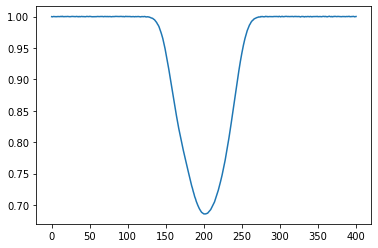

In [46]:
#DELETE AFTER PRESENTATION
print(training_coordinates[0])
plt.plot(training_intensities_noise[0])
plt.show()

In [47]:
if os.path.exists(f"{working_dir}/pca_model") == False:
    while True:
        # percent wished to be captured by the least number of components
        #cutoff = input("Please provide the percent of variance you wish to capture in the data (99% being 0.99 and 99.5% being 0.995): ")
        #cutoff = float(cutoff)
        #cutoff = 0.94 #To require 2 components when vel_eq=5.0
        cutoff = 0.99
        if 0 < cutoff < 1:
            initialize_cutoff = 0.0
            number_of_components = 0
            while initialize_cutoff <= cutoff:
                number_of_components += 1
                #initialize PCA with n components
                pca = PCA(n_components=number_of_components)
                # computes the principal components of the data and stores them in the pca object; fit method learns the transformation matrix that maps the input data to the principal components
                pca.fit(training_oots_intensities_noise)
                # applies the learned transformation matrix to the input data; projects the input data onto the principal components that were computed during the fitting process
                training_intensities_pca = pca.transform(training_oots_intensities_noise)
                # returns the amount of variance explained by each of the principal components
                var_exp = pca.explained_variance_ratio_
                eigenvalues = pca.explained_variance_
                initialize_cutoff = sum_array(var_exp)
            break
        else:
            print("Please enter values between 0 and 1 where 1% is 0.01 and 99% is 0.99")

    create_sub_folder(working_dir, "pca_model")
    pca_dir = f"{working_dir}/pca_model"
    joblib.dump(pca, f"{pca_dir}/pca_model")
    components = []
    for component in range(0, len(pca.components_)):
        pca_component = pca.components_[component]
        components.append(pca_component)
    cumulative_sum = []
    total = 0
    for value in var_exp:
        total += value
        cumulative_sum.append(total)
    tot_var = round(sum_array(var_exp) * 100, 4)
    sum_length = len(cumulative_sum)
    print("Dimensionality of transit profiles reduced using PCA...")
    print(f"{round(tot_var, 2)}% of the variance is captured by {number_of_components} principal components...")
    profiles_to_use = training_intensities_pca

    # pca profiles path
    intensities_pca_path = f'{working_dir}/princ_{number_of_components}_profiles.npy'
    training_intensities_pca_path = f'{prediction_dir}/training_princ_{number_of_components}_profiles.npy'
    np.save(training_intensities_pca_path, training_intensities_pca)
    pca_model = joblib.load(f"{pca_dir}/pca_model")
    intensities_pca = pca_model.transform(oot_sub_profiles) # 8
    np.save(intensities_pca_path, intensities_pca)

    # plot conditions
    figsize = (7, 7)
    titlesize = 25
    ticksize = 18
    labelsize = 18
    legendsize = 20
    linewidth = 2
    # plotting the scree plot and the individual components
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    # Scree Plot
    axes[0].set_title("Scree Plot", fontsize=titlesize)
    axes[0].plot(eigenvalues, linewidth=linewidth, color='C0', label=f'Total Variance: {round(tot_var, 2)}%')
    axes[0].plot(eigenvalues, marker='o', color='C0')
    axes[0].set_xticks(range(sum_length))
    axes[0].set_xticklabels([f'PC{i+1}' for i in range(sum_length)], rotation=45)
    axes[0].tick_params(axis='both', which='major', labelsize=ticksize)
    axes[0].set_xlabel("Principal Components", fontsize=labelsize)
    axes[0].set_ylabel("Eigenvalues", fontsize=labelsize)
    # Cumulative Variance Plot
    axes[1].set_title("Cumulative Variance", fontsize=titlesize)
    axes[1].plot(cumulative_sum, linewidth=linewidth, color='C0', label=f'Total Variance: {round(tot_var, 2)}%')
    axes[1].plot(cumulative_sum, marker='o', color='C0')
    axes[1].set_xticks(range(sum_length))
    axes[1].set_xticklabels([f'PC{i+1}' for i in range(sum_length)], rotation=45)
    axes[1].tick_params(axis='both', which='major', labelsize=ticksize)
    axes[1].set_xlabel("Principal Components", fontsize=labelsize)
    axes[1].set_ylabel("Percent Variance", fontsize=labelsize)
    axes[1].legend(fontsize=legendsize, loc='lower right')
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save and show plot
    plt.savefig(f"{working_dir}/pca_model/Scree_Var_Plots.pdf")
    plt.show()
    for component, i in zip(components, range(0, len(pca.components_))):
        title_var = i + 1
        plt.figure(figsize=figsize)
        plt.title(f"PC{title_var}", fontsize=titlesize)
        plt.plot(component, linewidth=linewidth, color=f'C{i+2}')
        plt.xticks(fontsize=ticksize)
        plt.yticks(fontsize=ticksize)
        plt.savefig(f'{working_dir}/pca_model/PC{i+1}.png')
        plt.show()

elif os.path.exists(f"{working_dir}/pca_model") == True:
    pca_dir = f"{working_dir}/pca_model"
    pca_model = joblib.load(f"{pca_dir}/pca_model")
    # Specify the pattern to look for
    pca_profile_file_pattern = re.compile(r'princ_(\d+)_profiles.npy')
    # Search for matching files in the directory
    matching_files = [file for file in os.listdir(working_dir) if pca_profile_file_pattern.match(file)]
    # Check if any matching files were found
    if matching_files:
        # Get the file name
        matching_file = matching_files[0]
        intensities_pca_path = os.path.join(working_dir, matching_file)
        # Load the existing pca profiles
        intensities_pca = np.load(intensities_pca_path)
        number_of_components = np.shape(intensities_pca)[1]
        training_intensities_pca_path = f'{prediction_dir}/training_princ_{number_of_components}_profiles.npy'
        training_intensities_pca = np.load(training_intensities_pca_path)
        print("PCA reduced profiles and training profiles retrieved from:")
        print(f"{intensities_pca_path}")
        print("and")
        print(f"{training_intensities_pca_path}")
    else:
        
        
        
        
        #edit you made just for this analysis. Uncomment the line below for normal use
        intensities_pca = pca_model.transform(oot_sub_profiles)
        number_of_components = np.shape(intensities_pca)[1]
        training_intensities_pca_path = f'{prediction_dir}/training_princ_{number_of_components}_profiles.npy'
        training_intensities_pca = np.load(training_intensities_pca_path)
        #end of edits
        
        
        
        print("No matching files found in the specified directory...")
        print("Something went wrong if you are seeing this error...")
    print("")
    print("PCA analysis has already been perfromed on this data set...")
    print("")
    print("The principle component plots and the scree plot can be located under:")
    print(f"{pca_dir}")
    print("")

PCA reduced profiles and training profiles retrieved from:
/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/0_deg/25_0/princ_6_profiles.npy
and
/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/0_deg/25_0/prediction_model/training_princ_6_profiles.npy

PCA analysis has already been perfromed on this data set...

The principle component plots and the scree plot can be located under:
/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/0_deg/25_0/pca_model



6 PCA projection profiles


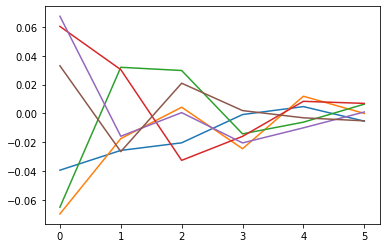

1500 PCA projection training profiles


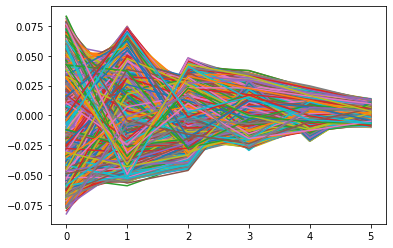

In [48]:
print(f"{len(intensities_pca)} PCA projection profiles")
for i in range(len(intensities_pca)):
    plt.plot(intensities_pca[i])
plt.show()
print(f"{len(training_intensities_pca)} PCA projection training profiles")
for i in range(len(training_intensities_pca)):
    plt.plot(training_intensities_pca[i])
plt.show()

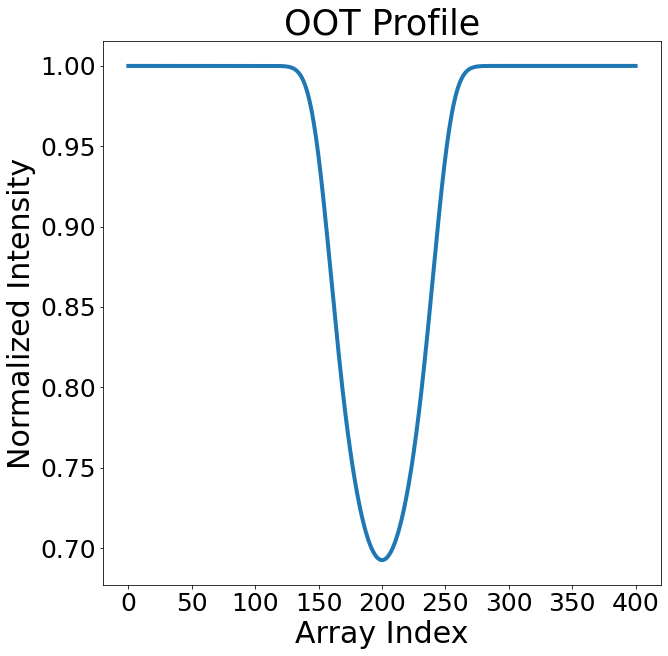

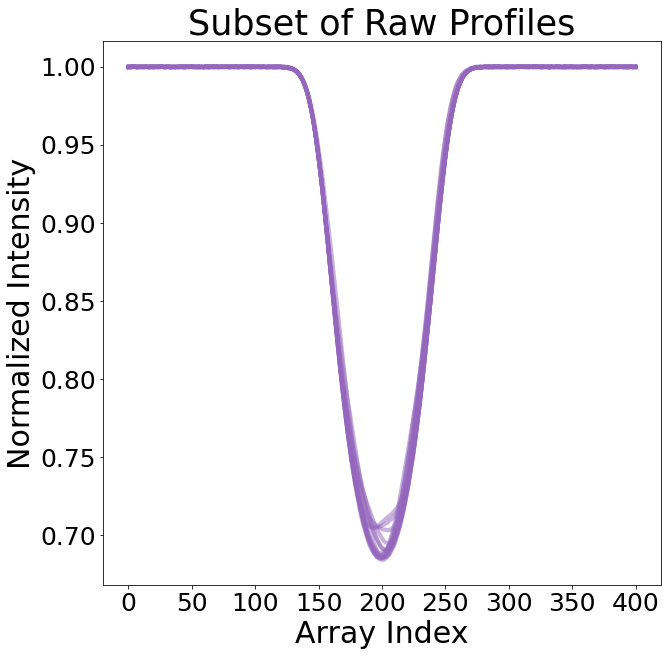

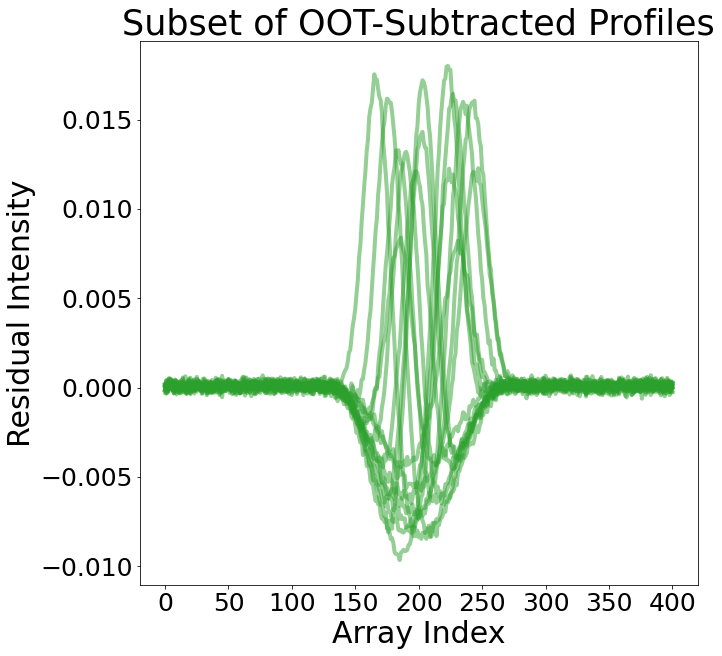

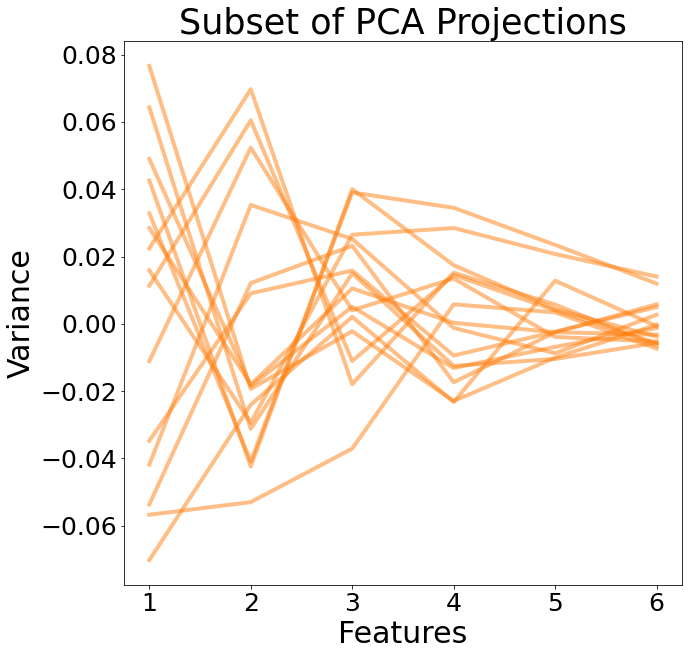

In [49]:
# plot conditions
# adjust how many samples to spot check (Example: 1, test_scale, train_scale, n)
glance_num = 15
figsize = (10,10)
titlesize = 35
ticksize = 25
linewidth = 4
labelsize = 30
markersize = 15

# plotting the OOT profiles
plt.figure(figsize=figsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
#plt.title(f'Training OOT Profile', fontsize=titlesize)
plt.title(f'OOT Profile', fontsize=titlesize)
plt.plot(training_oot_intensity_noise, color='C0', linewidth=linewidth)
plt.xlabel("Array Index", fontsize=labelsize)
plt.ylabel("Normalized Intensity", fontsize=labelsize)
#plt.savefig(f'{plt_dir_sub}/{label}_OOT_Profile.png')
plt.show()

# plotting the first few raw training profiles
plt.figure(figsize=figsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
if glance_num == 1:
    plt.title(f'First Raw Training Profile', fontsize=titlesize)
elif glance_num == n:
    plt.title(f'All Raw Training Profiles', fontsize=titlesize)
else:
    #plt.title(f'First {glance_num} Raw Training Profiles', fontsize=titlesize)
    plt.title(f'Subset of Raw Profiles', fontsize=titlesize)
for i in range(0, glance_num):
    plt.plot(training_intensities_noise[i], linewidth=linewidth, color="C4", alpha=0.5)
plt.xlabel("Array Index", fontsize=labelsize)
plt.ylabel("Normalized Intensity", fontsize=labelsize)
#plt.savefig(f'{plt_dir_sub}/{label}_Raw_Profiles.png')
plt.show()

# plotting the first few subtracted training profiles
plt.figure(figsize=figsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
if glance_num == 1:
    plt.title(f'First OOT-Subtracted Training Profile', fontsize=titlesize)
elif glance_num == n:
    plt.title(f'All OOT-Subtracted Training Profiles', fontsize=titlesize)
else:
    #plt.title(f'First {glance_num} OOT-Subtracted Training Profiles', fontsize=titlesize)
    plt.title(f'Subset of OOT-Subtracted Profiles', fontsize=titlesize)
for i in range(0, glance_num):
    plt.plot(training_oots_intensities_noise[i], linewidth=linewidth, color="C2", alpha=0.5)
plt.xlabel("Array Index", fontsize=labelsize)
plt.ylabel("Residual Intensity", fontsize=labelsize)
#plt.savefig(f'{plt_dir_sub}/{label}_OOT_Subtracted_Profiles.png')
plt.show()

# plotting the PCA profiles
plt.figure(figsize=figsize)
xtick_positions = np.arange(1, len(training_intensities_pca[0]) + 1)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
if glance_num == 1:
    plt.title(f'First PCA Projection', fontsize=titlesize)
elif glance_num == n:
    plt.title(f'All PCA Projections', fontsize=titlesize)
else:
    #plt.title(f'First {glance_num} PCA Projections', fontsize=titlesize)
    plt.title(f'Subset of PCA Projections', fontsize=titlesize)
for i in range(0, glance_num):
    plt.plot(xtick_positions, training_intensities_pca[i], linewidth=linewidth, color="C1", alpha=0.5)
plt.xlabel("Features", fontsize=labelsize)
plt.ylabel("Variance", fontsize=labelsize)
#plt.savefig(f'{plt_dir_sub}/{label}_PCA_Projections.png')
plt.show()

In [50]:
# finding shape of data for network input
network_input_dimension = np.shape(training_intensities_pca)[1]

# creating the coordinate and intensity training and test arrays
coords_train = training_coordinates[0:train_scale]
coords_test = training_coordinates[train_scale:n]
inten_train = training_intensities_pca[0:train_scale]
inten_test = training_intensities_pca[train_scale:n]

# defining data to enter network structure
x_train = inten_train
y_train = coords_train
x_test = inten_test
y_test = coords_test

In [51]:
dropout_rate=0.2
def profile_regression_model_structure(network_input_dimension, dropout_rate=dropout_rate):
    # Model structure
    input_activation = 'relu'
    hidden_activation = 'relu'
    output_activation = 'linear'

    # Building model layers
    model = keras.Sequential()
    model.add(keras.layers.Dense(150, input_dim=network_input_dimension, activation=input_activation))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(80, activation=hidden_activation))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(40, activation=hidden_activation))
    model.add(keras.layers.Dense(2, activation=output_activation))
    model.summary()

    return model

In [52]:
if os.path.exists(f"{prediction_dir}/model_ensemble") == False:

    create_sub_folder(prediction_dir, "model_ensemble")
    ensemble_dir = f"{prediction_dir}/model_ensemble"

    models = []

    train_start_time = time.time()
    for i in range(number_of_models):
        # Create a new instance of the model for each iteration
        model = profile_regression_model_structure(network_input_dimension)

        # Rest of your code remains unchanged
        loss = 'mean_squared_error'
        metrics = 'mean_absolute_error'
        optimizer = 'adam'

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        # Selecting epochs and batch size for model runs
        epochs = 250
        batch_size = 32

        # Callbacks
        checkpoints = ModelCheckpoint(f'{ensemble_dir}/prediction_regression_model_{i}.h5', monitor='loss', save_best_only=True, mode='min')
        log_csv = CSVLogger(f'{ensemble_dir}/prediction_regression_model_{i}.csv', separator=',', append=False)
        callback_list = [checkpoints, log_csv]

        # Fit the model
        history = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callback_list)

        # Save the model
        model.save(f'{ensemble_dir}/prediction_regression_model_{i}.h5')
        models.append(model)
    train_end_time = time.time()
    train_time = train_end_time-train_start_time
    print(f"Time to train {number_of_models} location regression models: {round((train_time)/60, 2)} minutes")
else:
    print(f"Regression model already exists under:")
    print(f"{prediction_dir}/model_ensemble")

Regression model already exists under:
/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/0_deg/25_0/prediction_model/model_ensemble


In [53]:
#if os.path.exists(f"{prediction_dir}/model_ensemble") == True:
#    ensemble_dir = f"{prediction_dir}/model_ensemble"

# Load models
#models = [tf.keras.models.load_model(f'{ensemble_dir}/prediction_regression_model_{i}.h5') for i in range(number_of_models)]

# Make predictions with each model
#predictions = [model.predict(x_test) for model in models]
# Ensemble the predictions (you can customize the ensemble method)
#ensemble_predictions = np.mean(predictions, axis=0)

In [54]:
if os.path.exists(f"{prediction_dir}/model_ensemble") == True:
    ensemble_dir = f"{prediction_dir}/model_ensemble"

# Initialize history_path and history
history_paths = [f'{ensemble_dir}/prediction_regression_model_{i}.csv' for i in range(number_of_models)]
histories = [pd.read_csv(history_path) for history_path in history_paths]
#epochs = history.index + 1

# model with min train mse
min_errors_train = []
model_min_MSE_indices_train = []
# Find top 10 models with minimum train MSE
for i, history in enumerate(histories):
    mse_values = history['loss'].values
    mae_values = history['mean_absolute_error'].values
    min_MSE_train = min(mse_values)
    min_errors_train.append(min_MSE_train)
    model_min_MSE_indices_train.append(i)
# Sort the errors and corresponding indices
sorted_indices_train = sorted(range(len(min_errors_train)), key=lambda k: min_errors_train[k])
top_10_indices_train = sorted_indices_train[:10]

# model with min test mse
min_mses_test = []
model_min_MSE_indices_test = []
# Find top 10 models with minimum test MSE
for i, history in enumerate(histories):
    mse_values_val = history['val_loss'].values
    mae_values_val = history['val_mean_absolute_error'].values
    min_MSE_test = min(mse_values_val)
    min_mses_test.append(min_MSE_test)
    model_min_MSE_indices_test.append(i)
# Sort the errors and corresponding indices
sorted_indices_test = sorted(range(len(min_mses_test)), key=lambda k: min_mses_test[k])
top_10_indices_test = sorted_indices_test[:10]

# Load the indeces of the models with minimum MSE
model_min_MSE_index_test = model_min_MSE_indices_test[0]
model_min_MSE_index_train = model_min_MSE_indices_train[0]
# Load the absolute best models
min_MSE_model_train = tf.keras.models.load_model(f'{ensemble_dir}/prediction_regression_model_{model_min_MSE_index_train}.h5')
min_MSE_model_test = tf.keras.models.load_model(f'{ensemble_dir}/prediction_regression_model_{model_min_MSE_index_test}.h5')
# Make predictions with smallest MSE models
min_MSE_predictions_train = min_MSE_model_train.predict(x_test)
min_MSE_predictions_test = min_MSE_model_test.predict(x_test)

# Load the top 10 models
models_top_ten_train = [tf.keras.models.load_model(f'{ensemble_dir}/prediction_regression_model_{idx}.h5') for idx in top_10_indices_train]
models_top_ten_test = [tf.keras.models.load_model(f'{ensemble_dir}/prediction_regression_model_{idx}.h5') for idx in top_10_indices_test]
# Make predictions with top ten
predictions_top_train = [model.predict(x_test) for model in models_top_ten_train]
predictions_top_test = [model.predict(x_test) for model in models_top_ten_test]
#Ensemble the predictions
ensemble_predictions_top_train = np.mean(predictions_top_train, axis=0)
ensemble_predictions_top_test = np.mean(predictions_top_test, axis=0)

# Load all models
models = [tf.keras.models.load_model(f'{ensemble_dir}/prediction_regression_model_{i}.h5') for i in range(number_of_models)]
# Make predictions with each model
predictions = [model.predict(x_test) for model in models]
# Ensemble the predictions
ensemble_predictions = np.mean(predictions, axis=0)

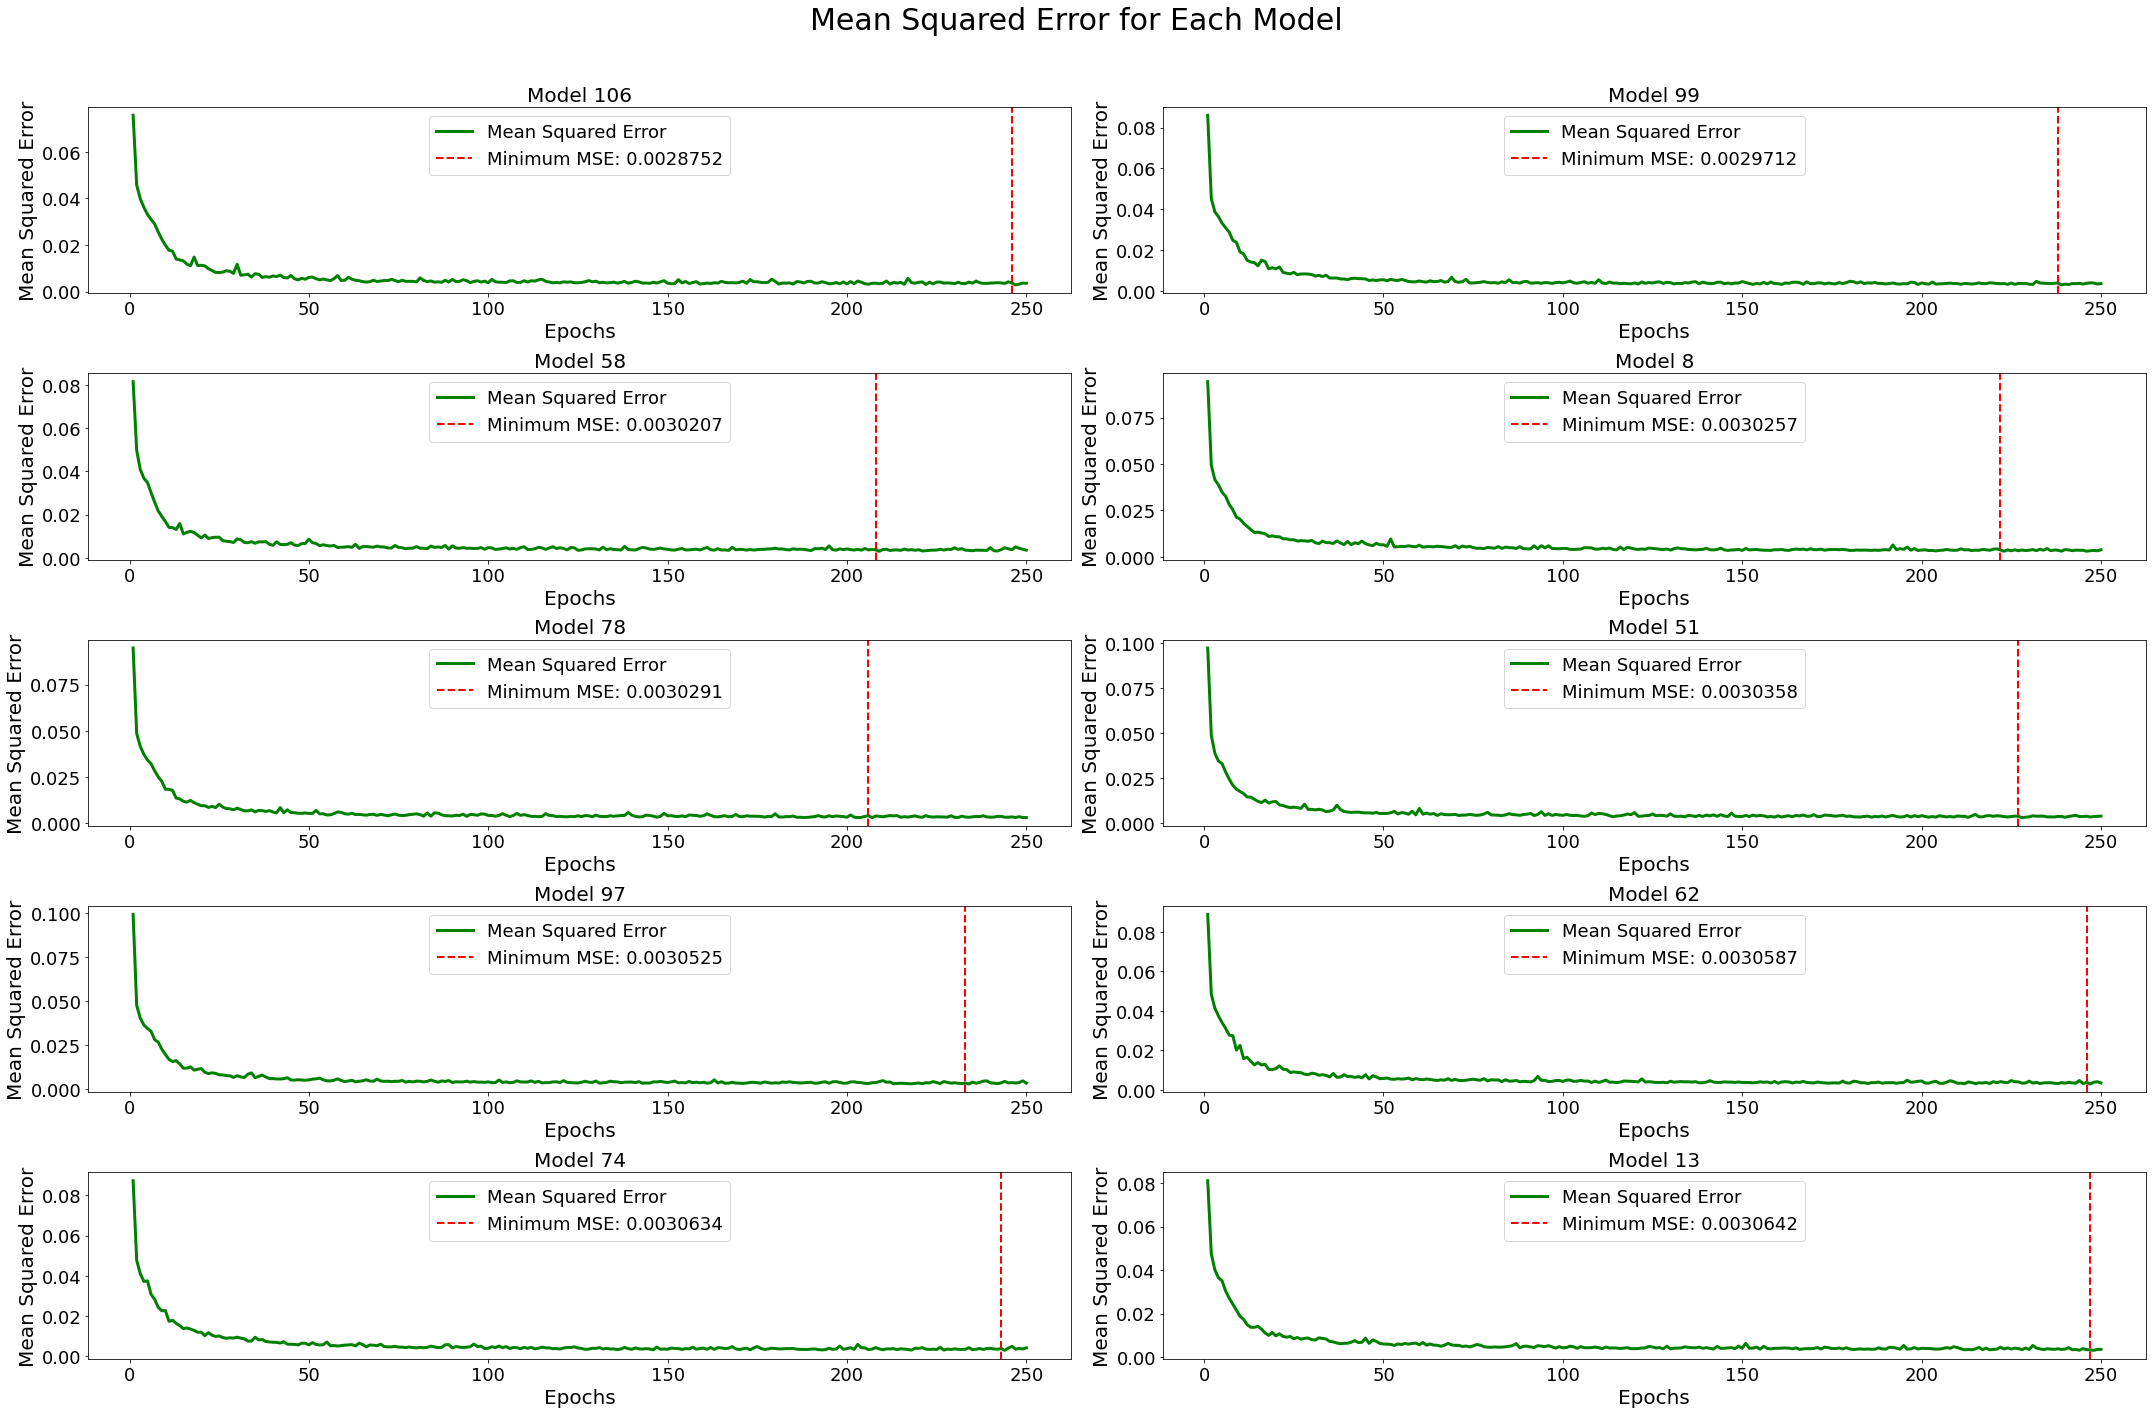

In [55]:
# Plot conditions
figsize = (30, 20)
titlesize = 30
subtitlesize = 20
ticksize = 18
labelsize = 20
linewidth = 3
legendsize = 18

# Number of rows and columns for the grid layout
num_rows, num_cols = 5, 2  # Define a 5x5 grid

# Initialize subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
fig.suptitle('Mean Squared Error for Each Model', fontsize=titlesize)

# Flatten the axes for easy indexing
axes = axes.flatten()

# Plot each model
for i, model_index in enumerate(top_10_indices_test):
    history_path = f'{ensemble_dir}/prediction_regression_model_{model_index}.csv'
    history = pd.read_csv(history_path)
    epochs = history.index + 1
    mse_values = history['val_loss'].values

    min_val_index_MSE = np.argmin(mse_values)  # Find the index of the minimum MSE
    min_MSE = mse_values[min_val_index_MSE]  # Retrieve the minimum MSE value

    ax = axes[i]
    ax.plot(epochs, mse_values, linewidth=linewidth, color='green')
    ax.axvline(min_val_index_MSE, linestyle='--', linewidth=2, color='r')
    ax.set_title(f'Model {model_index + 1}', fontsize=subtitlesize)
    ax.set_xlabel('Epochs', fontsize=labelsize)
    ax.set_ylabel('Mean Squared Error', fontsize=labelsize)
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.legend(['Mean Squared Error', f'Minimum MSE: {round(min_MSE, 7)}'], fontsize=legendsize)

# Hide any empty subplots
for ax in axes[len(top_10_indices_test):]:
    ax.axis('off')

# Adjust layout and save the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

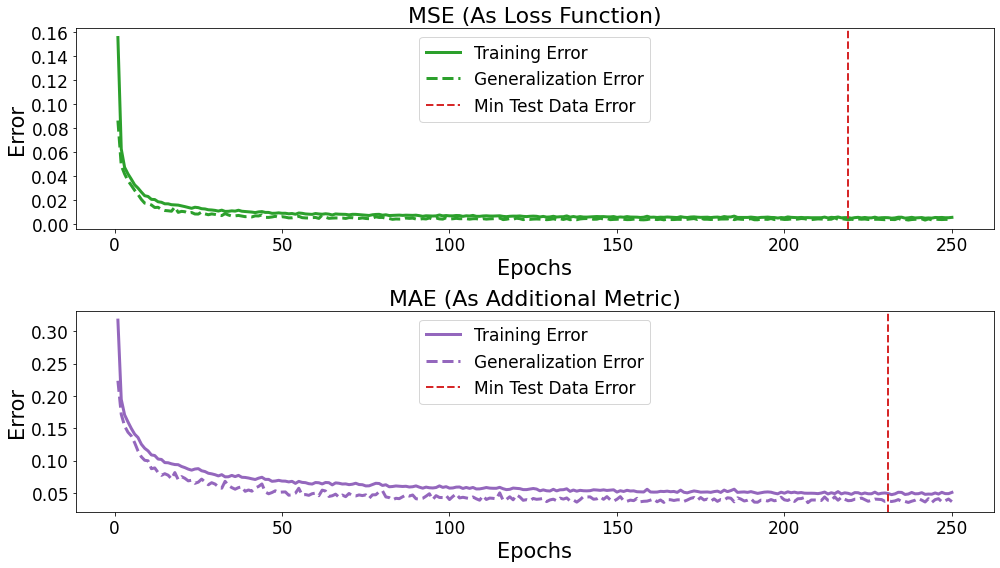

In [56]:
# Assuming you have the path to the training history CSV file
history_path_best = f'{ensemble_dir}/prediction_regression_model_{model_min_MSE_index_test}.csv'
# Load the training history from the CSV file
history_best = pd.read_csv(history_path_best)
# Access the necessary metrics from the loaded history
mse_values_best = history_best['loss']
mse_values_val_best = history_best['val_loss']
mae_values_best = history_best['mean_absolute_error']
mae_values_val_best = history_best['val_mean_absolute_error']
# Find the indices of the lowest MSE and MAE values
min_val_index_MSE_best = mse_values_best.idxmin()
min_val_index_MAE_best = mae_values_best.idxmin()
#print(min_val_index_MSE_best)
#print(min_val_index_MAE_best)

figsize=(14,8)
labelsize = 21
legendsize = 17
titlesize = 22
ticksize = 17

# Set figure size
plt.figure(figsize=figsize)

# Plot MSE information
plt.subplot(2, 1, 1)
plt.title("MSE (As Loss Function)", fontsize=titlesize)
plt.plot(epochs, mse_values_best, linewidth=linewidth, color='C2', label='Training Error')
plt.plot(epochs, mse_values_val_best, linewidth=linewidth, linestyle='--', color='C2', label='Generalization Error')
plt.axvline(min_val_index_MSE_best, linestyle='--', linewidth=2, color='C3', label='Min Test Data Error')
plt.xlabel("Epochs", fontsize=labelsize)
plt.ylabel("Error", fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.legend(loc='upper center', fontsize=legendsize)

# Plot MAE information
plt.subplot(2, 1, 2)
plt.title("MAE (As Additional Metric)", fontsize=titlesize)
plt.plot(epochs, mae_values_best, linewidth=linewidth, color='C4', label='Training Error')
plt.plot(epochs, mae_values_val_best, linewidth=linewidth, linestyle='--', color='C4', label='Generalization Error')
plt.axvline(min_val_index_MAE_best, linestyle='--', linewidth=2, color='C3', label='Min Test Data Error')
plt.xlabel("Epochs", fontsize=labelsize)
plt.ylabel("Error", fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.legend(loc='upper center', fontsize=legendsize)
# Adjust layout
plt.tight_layout()
# Show plot
plt.show()

# Saving the data
#np.save(f"epochs_{target_vel}.npy", epochs)
#np.save(f"mse_values_{target_vel}.npy", mse_values)
#np.save(f"min_index_{target_vel}", min_val_index_MSE)

In [57]:
# creating arrays for the x-coordinates and y-coordinates for each subset
(training_x, training_y) = y_train.T                               #training coordinate points
(test_x, test_y) = y_test.T                                        #test coordinate points
(ensemble_pred_x, ensemble_pred_y) = ensemble_predictions.T        #all models ensembled
(top_ten_pred_x, top_ten_pred_y) = ensemble_predictions_top_test.T #top 10 models ensembled
(min_MSE_pred_x, min_MSE_pred_y) = min_MSE_predictions_test.T      #best model

In [58]:
#-------funciton initiating general scalings for plotting-----
def star_patch_conditions(labelsize, ticksize, hemisphere):
    plt.xlabel("Normalized Stellar Radius (x)", fontsize=labelsize)
    plt.ylabel("Normalized Stellar Radius (y)", fontsize=labelsize)
    plt.xlim(-1.1, 1.1)
    plt.xticks(np.arange(-1, 1.25, 0.25), fontsize=ticksize)
    if hemisphere=='upper':
        plt.ylim(-0.05, 1.1)
        plt.yticks(np.arange(0, 1.25, 0.25), fontsize=ticksize)
    elif hemisphere=='lower':
        plt.ylim(-1.1, 0.05)
        plt.yticks(np.arange(-1, 0.25, 0.25), fontsize=ticksize)
    elif hemisphere=='both':
        plt.ylim(-1.1, 1.1)
        plt.yticks(np.arange(-1, 1.25, 0.25), fontsize=ticksize)
    plt.gca().set_aspect('equal')
#-------function that traces the "star" outline-------
def star_patch_outline(r, starwidth):
    star = plt.Circle((0, 0), r, linewidth=starwidth, color='k', fill=False, zorder=2)
    plt.gca().add_patch(star)
#-------functions for generating center lines-------
def star_patch_equator(hemiwidth):
    plt.plot([-1, 1], [0,0], '-', linewidth=hemiwidth, color='k', zorder=2)
def star_patch_meridian(hemiwidth):
    plt.vlines(x=0, ymin=-1, ymax=1, linestyles='-', linewidth=hemiwidth, colors = 'k', zorder=2)
def star_patch_center_lines(hemiwidth):
    plt.plot([-1, 1], [0,0], '-', linewidth=hemiwidth, color='k', zorder=2)
    plt.vlines(x=0, ymin=-1, ymax=1, linestyles='-', linewidth=hemiwidth, colors = 'k', zorder=2)
#-------functions for generating gridlines-------
def horizontal_line_convert(h):
    half_length = (1 - h**2)**(1/2)
    return half_length
def horizontal_line_range(h):
    plot_conditions = [(-1) * horizontal_line_convert(h), horizontal_line_convert(h)]
    return plot_conditions
def vertical_grid_line_convert(x):
    if hemisphere=='upper':
        height = (1 - x**2)**(1/2)
    elif hemisphere=='lower':
        height = -(1 - x**2)**(1/2)
    return height
def vertical_grid_line_convert_whole(x):
    height_upper = (1 - x**2)**(1/2)
    height_lower = -(1 - x**2)**(1/2)
    return height_upper, height_lower
def star_grid_overlay(grid_dimension, gridwidth, hemisphere):
    vertical_line_spacings = np.linspace(-1, 1, 2*grid_dimension-1)
    vertical_line_heights = []
    vertical_line_heights_upper = []
    vertical_line_heights_lower = []
    if hemisphere=='upper':
        horizontal_line_heights = np.linspace(0, 1, grid_dimension)
    elif hemisphere=='lower':
        horizontal_line_heights = np.linspace(-1, 0, grid_dimension)
    elif hemisphere=='both':
        horizontal_line_heights = np.linspace(-1, 1, 2*grid_dimension-1)
    if hemisphere=='both':
        for i in vertical_line_spacings:
            upper_height = vertical_grid_line_convert_whole(i)[0]
            lower_height = vertical_grid_line_convert_whole(i)[1]
            vertical_line_heights_upper.append(upper_height)
            vertical_line_heights_lower.append(lower_height)
        #-------overlaying grid lines-------
        for i in horizontal_line_heights:
            plt.plot(horizontal_line_range(i), [i,i], '--', linewidth=gridwidth, color='k', zorder=1)
        for i,j in zip(vertical_line_spacings, vertical_line_heights_upper):
            plt.vlines(x=i, ymin=0, ymax=j, linestyles='--', linewidth=gridwidth, colors = 'k', zorder=1)
        for i,j in zip(vertical_line_spacings, vertical_line_heights_lower):
            plt.vlines(x=i, ymin=0, ymax=j, linestyles='--', linewidth=gridwidth, colors = 'k', zorder=1)
    else:
        for i in vertical_line_spacings:
            new_height = vertical_grid_line_convert(i)
            vertical_line_heights.append(new_height)
        #-------overlaying grid lines-------
        for i in horizontal_line_heights:
            plt.plot(horizontal_line_range(i), [i,i], '--', linewidth=gridwidth, color='k', zorder=1)
        for i,j in zip(vertical_line_spacings, vertical_line_heights):
            plt.vlines(x=i, ymin=0, ymax=j, linestyles='--', linewidth=gridwidth, colors = 'k', zorder=1)

In [59]:
#-------functions for plot backgrounds-------
def star_patch_limb_dark(r, alpha, color):
    star = plt.Circle((0, 0), r, linewidth=starwidth, color=color, fill=False, alpha=alpha)
    plt.gca().add_patch(star)
def vertical_RM_line_convert(x):
    height_RM = (1 - x**2)**(1/2)
    return height_RM
def LD_background():
    r_steps = 500 #CHANGE ME (number of patches that make up LD gradient)
    r_yellow_start, r_yellow_stop = (1 - 1/r_steps), 0
    r_yellow = np.linspace(r_yellow_start, r_yellow_stop, r_steps)
    alpha_yellow = np.linspace(0.5, 0, r_steps)
    r_black_start, r_black_stop = 1, (0.25 + 1/r_steps)
    r_black = np.linspace(r_black_start, r_black_stop, r_steps)
    alpha_black = np.linspace(0.1, 0, int(r_steps/2))
    #-------patching in star structure and color layers-------
    for i,j in zip(r_yellow, alpha_yellow):
        star_patch_limb_dark(i, j, 'yellow')
    for i,j in zip(r_black, alpha_black):
        star_patch_limb_dark(i, j, 'k')
def RM_background():
    x_steps = 1500 #CHANGE ME (number of x-lines that make up RM gradient)
    x = np.linspace(-1, 1, x_steps)
    alpha_blue = np.linspace(0.08, 0, int(3/4*x_steps))
    alpha_red = np.linspace(0, 0.08, int(3/4*x_steps))
    vertical_line_range_blue = np.linspace(-1, 0, int(3/4*x_steps)) #zero parody
    vertical_line_range_red = np.linspace(0, 1, int(3/4*x_steps))
    #-------collecting vertical line heights-------
    vertical_line_heights_blue = []
    vertical_line_heights_red = []
    for i in vertical_line_range_blue:
        new_height = vertical_RM_line_convert(i)
        vertical_line_heights_blue.append(new_height)
    for i in vertical_line_range_red:
        new_height = vertical_RM_line_convert(i)
        vertical_line_heights_red.append(new_height)
    #-------filling in the RM lines-------
    for i,j,k in zip(vertical_line_range_blue, vertical_line_heights_blue, alpha_blue):
        plt.vlines(x=i, ymin=-j, ymax=j, linewidth=linewidthRM, colors = 'blue', alpha=k)
    for i,j,k in zip(vertical_line_range_red, vertical_line_heights_red, alpha_red):
        plt.vlines(x=i, ymin=-j, ymax=j, linewidth=linewidthRM, colors = 'red', alpha=k)

In [60]:
# functions for plotting build model points
def plot_scatter_points(x, y, marker, markersize, color, zorder):
    if marker == "o":
        points = plt.scatter(x, y, s=markersize, marker="o", color=color, edgecolor='k', zorder=zorder)
    elif marker == "x":
        points = plt.scatter(x, y, s=markersize, marker="x", color=color, zorder=zorder)
    else:
        points = None
        print('Please set marker type to either "o" or "x"...')
    return points

def plot_scatter_points_cmap(x_cmap, y_cmap, x_model, y_model, markersize, zorder):
    color = np.log((((x_model-x_cmap)**2) + ((y_model-y_cmap)**2))**(1/2))
    points = plt.scatter(x_cmap, y_cmap, s=markersize, marker ="o", c=color, edgecolor='k', zorder=zorder)
    return points

# function for plotting error lines
def plot_error_lines(x_test, y_test, x_model, y_model, errorlinewidth, zorder):
    global points
    li_test = list(zip(x_test, y_test))
    points = len(li_test)
    li_pred = list(zip(x_model, y_model))
    xs_test = [x[0] for x in li_test]
    xs_pred = [x[0] for x in li_pred]
    xs_concat = np.stack((xs_test, xs_pred), axis=1)
    ys_test = [x[1] for x in li_test]
    ys_pred = [x[1] for x in li_pred]
    ys_concat = np.stack((ys_test, ys_pred), axis=1)
    for i in range(0, len(li_test)):
        plt.plot(xs_concat[i], ys_concat[i], ':', linewidth=errorlinewidth, color='k', zorder=zorder)

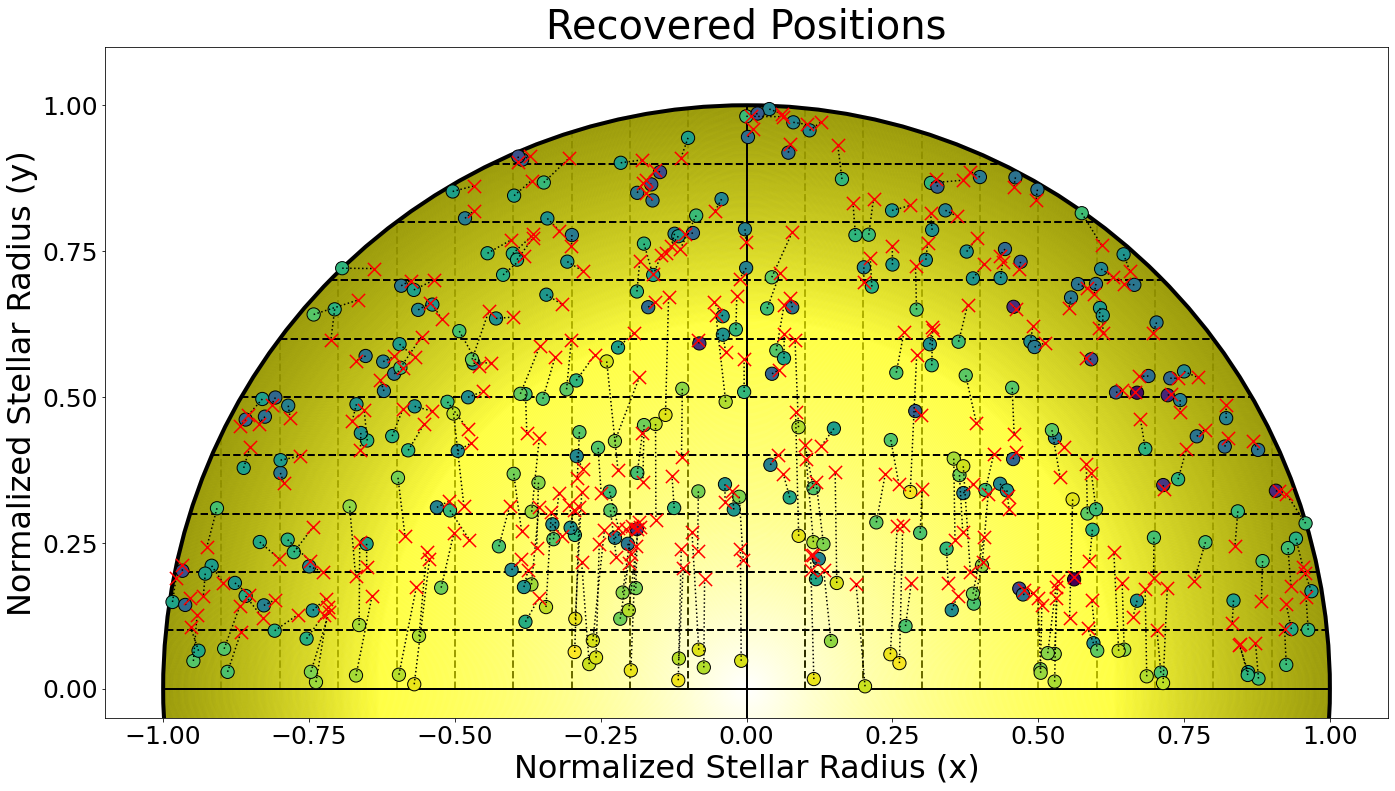

In [67]:
#DELETE AFTER PRESENTATION!######################################################################################

# general plot conditions
errorlinewidth=1.5
figsize=(23, 23) #26,26 for test points
gridwidth=2
hemiwidth=2
labelsize=32
legendsize=22
linewidthRM=4
markersize=175
starwidth=4
ticksize=25
titlesize=40

# generating plot
plt.figure(figsize=figsize)
star_patch_outline(1, starwidth)
star_grid_overlay(11, gridwidth, "upper")
#plt.title(f'Min. MSE Test Data Fit Stellar Surface Grid: {velocity_prediction:.4f} km/s', fontsize=titlesize)
plt.title(f'Recovered Positions', fontsize=titlesize)
star_patch_conditions(labelsize, ticksize, "upper")

# toggling central grid lines
#star_patch_equator(hemiwidth)
#star_patch_meridian(hemiwidth)
star_patch_center_lines(hemiwidth)

# data to plot
#training_points = plot_scatter_points(training_x, training_y, "o", markersize, 'b', 1)
#test_points = plot_scatter_points(test_x, test_y, "o", markersize, 'g', 2)
test_points_cmap = plot_scatter_points_cmap(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, markersize, 3) #2
#ensembled_points = plot_scatter_points(ensemble_pred_x, ensemble_pred_y, "x", markersize, 'k', 3)
min_MSE_points = plot_scatter_points(min_MSE_pred_x, min_MSE_pred_y, "x", markersize, 'r', 4)

# error lines
#ensembled_points_fit_error = plot_error_lines(test_x, test_y, ensemble_pred_x, ensemble_pred_y, errorlinewidth, 1)
min_MSE_points_fit_error = plot_error_lines(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, errorlinewidth, 3) #1

# plot backgrounds
LD_background()
#RM_background()

# producing plot

#plt.legend((test_points_cmap, min_MSE_points), (f'Simulated Test Coordinates', f'Model Predicted Coordinates'), fontsize=legendsize, loc="upper right")

# Adding the color bar
#barsize=0.43
#barticksize=ticksize-2
#barlabelsize=labelsize-2
#annotatesize=35
#ticks = [0, (1/4 * max_error_parameter), (1/2 * max_error_parameter), (3/4 * max_error_parameter), max_error_parameter]
#colorbar = plt.colorbar(ticks=ticks, format='%.2f', shrink=barsize)
#colorbar.set_label('Fit Residuals', fontsize=barlabelsize)
#colorbar.ax.tick_params(labelsize=barticksize)  # Adjust font size of color bar label
#plt.clim(0, max_error_parameter)

plt.show()

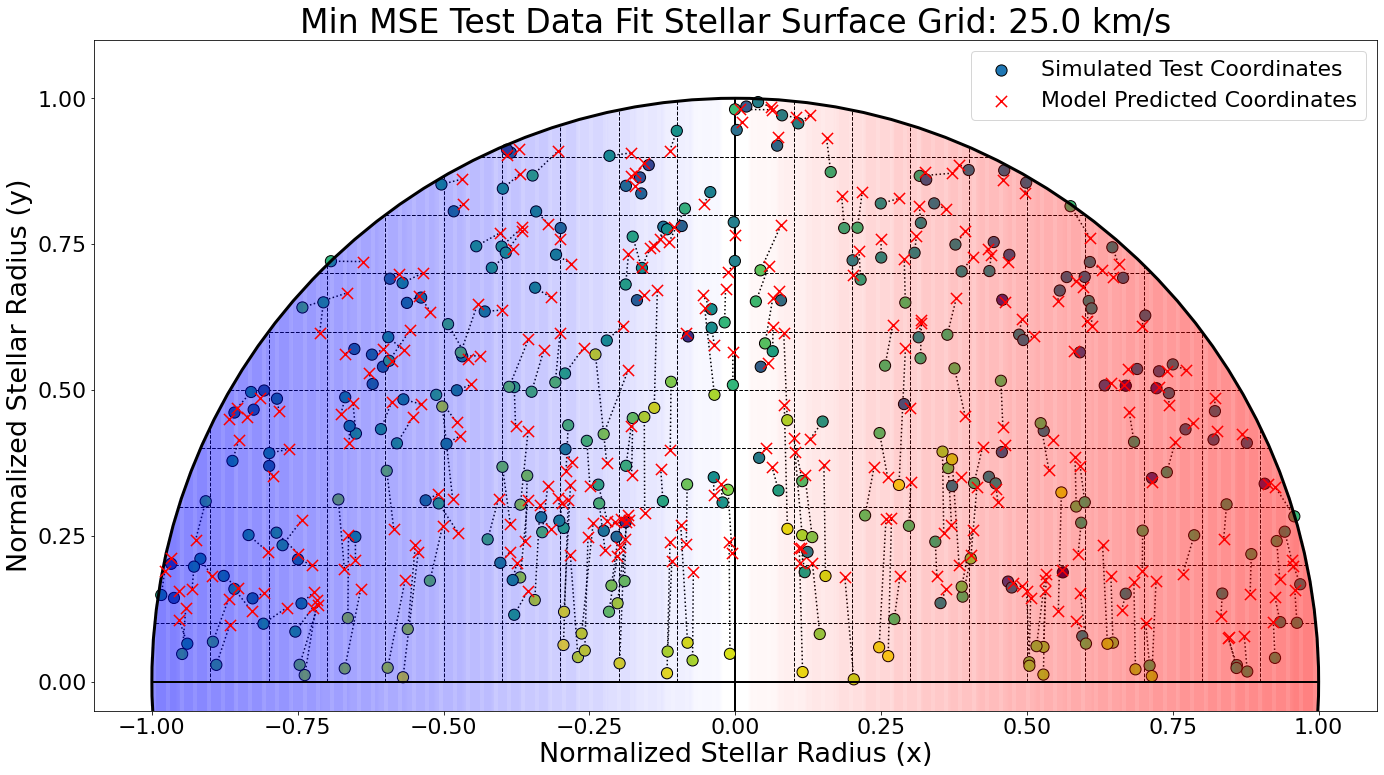

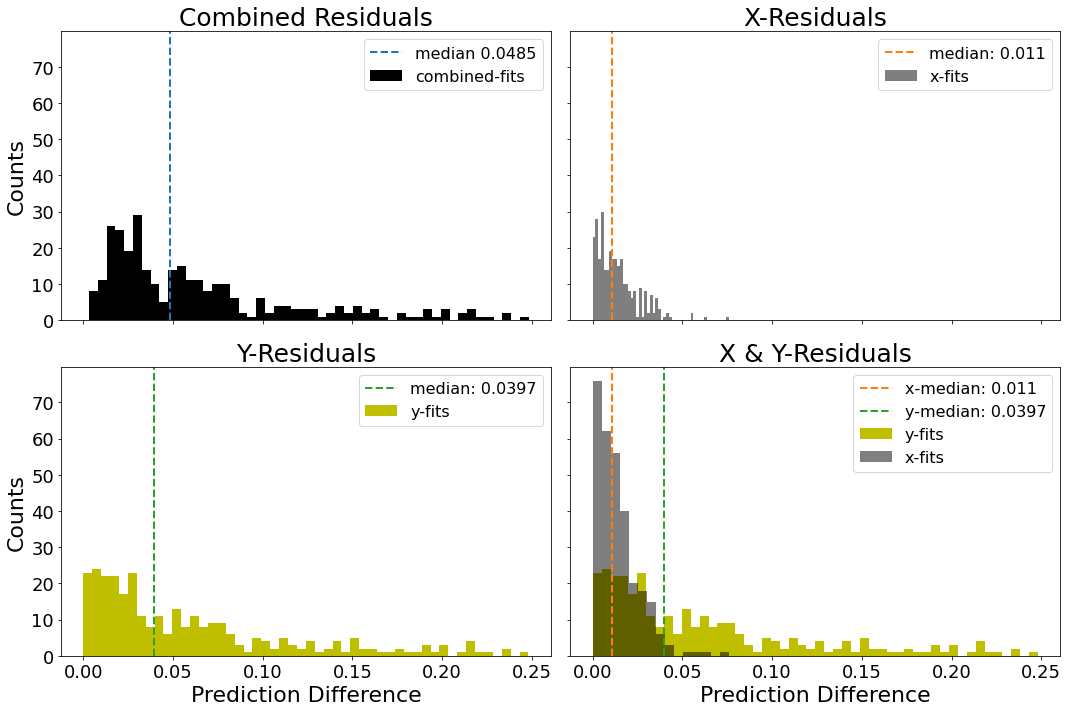

In [64]:
# general plot conditions
errorlinewidth=1.5
figsize=(23, 23)
gridwidth=1
hemiwidth=2
labelsize=27
legendsize=22
linewidthRM=4
markersize=125
starwidth=3
ticksize=22
titlesize=33

# generating plot
plt.figure(figsize=figsize)
star_patch_outline(1, starwidth)
star_grid_overlay(11, gridwidth, "upper")
#plt.title(f'Min. MSE Test Data Fit Stellar Surface Grid: {velocity_prediction:.4f} km/s', fontsize=titlesize)
plt.title(f'Min MSE Test Data Fit Stellar Surface Grid: {target_vel} km/s', fontsize=titlesize)
star_patch_conditions(labelsize, ticksize, "upper")

# toggling central grid lines
#star_patch_equator(hemiwidth)
#star_patch_meridian(hemiwidth)
star_patch_center_lines(hemiwidth)

# data to plot
#training_points = plot_scatter_points(training_x, training_y, "o", markersize, 'b', 1)
#test_points = plot_scatter_points(test_x, test_y, "o", markersize, 'k', 2)
test_points_cmap = plot_scatter_points_cmap(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, markersize, 2)
#ensembled_points = plot_scatter_points(ensemble_pred_x, ensemble_pred_y, "x", markersize, 'k', 3)
min_MSE_points = plot_scatter_points(min_MSE_pred_x, min_MSE_pred_y, "x", markersize, 'r', 4)

# error lines
#ensembled_points_fit_error = plot_error_lines(test_x, test_y, ensemble_pred_x, ensemble_pred_y, errorlinewidth, 1)
min_MSE_points_fit_error = plot_error_lines(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, errorlinewidth, 1)

# plot backgrounds
#LD_background()
#RM_background()

# producing plot
plt.legend((test_points_cmap, min_MSE_points), (f'Simulated Test Coordinates', f'Model Predicted Coordinates'), fontsize=legendsize, loc="upper right")
plt.savefig(f'{prediction_dir}/Min_MSE_SSG.png')
plt.show()

alpha=0.5
bins=50
figsize=(15, 10)
labelsize=22
legendsize=16
linewidth=2
ticksize=18
titlesize=25

#analysing the residuals
def plot_model_variability(x_test, y_test, x_model, y_model):
    #-------subplot structure-------
    fig, axs = plt.subplots(2, 2,  figsize=figsize, sharex=True, sharey=True)
    x_variability = ((x_model-x_test)**2)**0.5
    y_variability = ((y_model-y_test)**2)**0.5
    comb_variability = ((x_model-x_test)**2 + (y_model-y_test)**2)**0.5
    x_var_range = max(x_variability)-min(x_variability)
    y_var_range = max(y_variability)-min(y_variability)
    y_bin_length = y_var_range/bins
    x_bin_num = int(x_var_range/y_bin_length)
    #-------visualizing combined fits-------
    axs[0, 0].set_title('Combined Residuals', fontsize=titlesize)
    axs[0, 0].tick_params(axis='both', which='major', labelsize=ticksize)
    axs[0, 0].set_ylabel('Counts', fontsize=labelsize)
    axs[0, 0].hist(comb_variability, bins=bins, color='k', label=f'combined-fits')
    axs[0, 0].axvline(np.median(comb_variability), linestyle='--', linewidth=linewidth, color='C0', label=f'median {round(np.median(comb_variability), 4)}')
    axs[0, 0].legend(fontsize=legendsize)
    #------visualizing x fits-------
    axs[0, 1].set_title('X-Residuals', fontsize=titlesize)
    axs[0, 1].tick_params(axis='both', which='major', labelsize=ticksize)
    axs[0, 1].hist(x_variability, bins=bins, alpha=alpha, color='k', label=f'x-fits')
    axs[0, 1].axvline(np.median(x_variability), linestyle='--', linewidth=linewidth, color='C1', label=f'median: {round(np.median(x_variability), 4)}')
    axs[0, 1].legend(fontsize=legendsize)
    #-------visualizing y fits-------
    axs[1, 0].set_title('Y-Residuals', fontsize=titlesize)
    axs[1, 0].tick_params(axis='both', which='major', labelsize=ticksize)
    axs[1, 0].set_xlabel('Prediction Difference', fontsize=labelsize), axs[1, 0].set_ylabel('Counts', fontsize=labelsize)
    axs[1, 0].hist(y_variability, bins=bins, color='y', label=f'y-fits')
    axs[1, 0].axvline(np.median(y_variability), linestyle='--', linewidth=linewidth, color='C2', label=f'median: {round(np.median(y_variability), 4)}')
    axs[1, 0].legend(fontsize=legendsize)
    #-------visualizing xy fits-------
    axs[1, 1].set_title('X & Y-Residuals', fontsize=titlesize)
    axs[1, 1].tick_params(axis='both', which='major', labelsize=ticksize)
    axs[1, 1].set_xlabel('Prediction Difference', fontsize=labelsize)
    axs[1, 1].hist(y_variability, bins=bins, alpha=1, color='y', label=f'y-fits')
    axs[1, 1].hist(x_variability, bins=x_bin_num, alpha=alpha, color='k', label=f'x-fits')
    axs[1, 1].axvline(np.median(x_variability), linestyle='--', linewidth=linewidth, color='C1', label=f'x-median: {round(np.median(x_variability), 4)}')
    axs[1, 1].axvline(np.median(y_variability), linestyle='--', linewidth=linewidth, color='C2', label=f'y-median: {round(np.median(y_variability), 4)}')
    axs[1, 1].legend(fontsize=legendsize)
    #-------saving plot-------
    fig.tight_layout()
    plt.savefig(f'{prediction_dir}/SSG_Residule_Plots.png')
    plt.show()

plot_model_variability(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y)

In [31]:
# general plot conditions
errorlinewidth=1.5
figsize=(23, 27)
gridwidth=1
hemiwidth=2
labelsize=27
legendsize=18
linewidthRM=4
markersize=150
starwidth=3
ticksize=22
titlesize=33
barsize=0.75
barticksize=ticksize-2
barlabelsize=labelsize-2
annotatesize=35

# Now, create a new figure that will encompass both plots
combined_fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize, gridspec_kw={'hspace': 0.3})

# Generating plot 1
plt.sca(axes[0])
star_patch_outline(1, starwidth)
star_grid_overlay(11, gridwidth, "upper")
plt.title(f'Training Data: {target_vel} km/s', fontsize=titlesize)
star_patch_conditions(labelsize, ticksize, "upper")
star_patch_center_lines(hemiwidth)
plot_scatter_points(training_x, training_y, "o", markersize, 'b', 1)  # Plot directly without saving the result
plt.annotate('a', xy=(-0.1, 1.1), xycoords='axes fraction', fontsize=annotatesize, weight='bold')
plt.close()  # Close the figure without displaying

# Generating plot 2
plt.sca(axes[1])
star_patch_outline(1, starwidth)
star_grid_overlay(11, gridwidth, "upper")
plt.title(f'Model Fit to Test Data: {target_vel} km/s', fontsize=titlesize)
star_patch_conditions(labelsize, ticksize, "upper")
star_patch_center_lines(hemiwidth)
test_points_cmap = plot_scatter_points_cmap(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, markersize, 2)
min_MSE_points = plot_scatter_points(min_MSE_pred_x, min_MSE_pred_y, "x", markersize, 'r', 4)
min_MSE_points_fit_error = plot_error_lines(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, errorlinewidth, 1)
plt.legend((test_points_cmap, min_MSE_points), (f'Simulated Test Coordinates', f'Model Predicted Coordinates'), fontsize=legendsize, loc="upper right")
plt.annotate('b', xy=(-0.1, 1.1), xycoords='axes fraction', fontsize=annotatesize, weight='bold')
plt.close()  # Close the figure without displaying

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure as a single PDF file
combined_fig.savefig('combined_plots_training_test.pdf')

# Now, create a new figure that will encompass both plots
#combined_fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize, gridspec_kw={'hspace': 0.2})
combined_fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)

# Generating plot 1
plt.sca(axes[0])
max_error_parameter = np.max((((min_MSE_pred_x - test_x)**2) + ((min_MSE_pred_y - test_y)**2))**(1/2))
star_patch_outline(1, starwidth)
star_grid_overlay(11, gridwidth, "upper")
plt.title(f'Predictions and the RM Effect', fontsize=titlesize)
star_patch_conditions(labelsize, ticksize, "upper")
star_patch_center_lines(hemiwidth)
RM_background()
#test_points = plot_scatter_points(test_x, test_y, "o", markersize, 'gray', 2)
test_points = plot_scatter_points_cmap(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, markersize, 2)
min_MSE_points = plot_scatter_points(min_MSE_pred_x, min_MSE_pred_y, "x", markersize, 'r', 4)
min_MSE_points_fit_error = plot_error_lines(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, errorlinewidth, 1)
plt.legend((test_points, min_MSE_points), (f'Simulated Test Coordinates', f'Model Predicted Coordinates'), fontsize=legendsize, loc="upper right")
ticks = [0, (1/4 * max_error_parameter), (1/2 * max_error_parameter), (3/4 * max_error_parameter), max_error_parameter]
colorbar = plt.colorbar(ticks=ticks, format='%.2f', shrink=barsize)
colorbar.set_label('Fit Residual', fontsize=barlabelsize)
colorbar.ax.tick_params(labelsize=barticksize)  # Adjust font size of color bar label
plt.clim(0, max_error_parameter)
plt.annotate('a', xy=(-0.1, 1.1), xycoords='axes fraction', fontsize=annotatesize, weight='bold')
plt.close()  # Close the figure without displaying

# Generating plot 2
plt.sca(axes[1])
max_error_parameter = np.max((((min_MSE_pred_x - test_x)**2) + ((min_MSE_pred_y - test_y)**2))**(1/2))
star_patch_outline(1, starwidth)
star_grid_overlay(11, gridwidth, "upper")
plt.title(f'Predictions and Limb Darkening', fontsize=titlesize)
star_patch_conditions(labelsize, ticksize, "upper")
star_patch_center_lines(hemiwidth)
LD_background()
#test_points = plot_scatter_points(test_x, test_y, "o", markersize, 'gray', 2)
test_points = plot_scatter_points_cmap(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, markersize, 2)
min_MSE_points = plot_scatter_points(min_MSE_pred_x, min_MSE_pred_y, "x", markersize, 'r', 4)
min_MSE_points_fit_error = plot_error_lines(test_x, test_y, min_MSE_pred_x, min_MSE_pred_y, errorlinewidth, 1)
plt.legend((test_points, min_MSE_points), (f'Simulated Test Coordinates', f'Model Predicted Coordinates'), fontsize=legendsize, loc="upper right")
ticks = [0, (1/4 * max_error_parameter), (1/2 * max_error_parameter), (3/4 * max_error_parameter), max_error_parameter]
colorbar = plt.colorbar(ticks=ticks, format='%.2f', shrink=barsize)
colorbar.set_label('Fit Residual', fontsize=barlabelsize)
colorbar.ax.tick_params(labelsize=barticksize)  # Adjust font size of color bar label
plt.clim(0, max_error_parameter)
plt.annotate('b', xy=(-0.1, 1.1), xycoords='axes fraction', fontsize=annotatesize, weight='bold')
plt.close()  # Close the figure without displaying

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure as a single PDF file
combined_fig.savefig('combined_plots_backgrounds.pdf')

<Figure size 432x288 with 0 Axes>

In [32]:
#loading in the models and asking them to predict on transit data points

# Make predictions with each model
transit_predictions = [model.predict(intensities_pca) for model in models]
transit_ensemble_predictions = np.mean(transit_predictions, axis=0)
transit_top_predictions = [model.predict(intensities_pca) for model in models_top_ten_test]
transit_ensemble_top_ten_predictions = np.mean(transit_top_predictions, axis=0)
transit_min_MSE_test_predictions = min_MSE_model_test.predict(intensities_pca)
transit_min_MSE_train_predictions = min_MSE_model_train.predict(intensities_pca)

# creating arrays for the x-coordinates and y-coordinates for each subset
(transit_ensemble_pred_x, transit_ensemble_pred_y) = transit_ensemble_predictions.T
(transit_top_ten_pred_x, transit_top_ten_pred_y) = transit_ensemble_top_ten_predictions.T
(transit_min_MSE_train_pred_x, transit_min_MSE_train_pred_y) = transit_min_MSE_train_predictions.T
(transit_min_MSE_test_pred_x, transit_min_MSE_test_pred_y) = transit_min_MSE_test_predictions.T

# all models
x_coordinates_list = []
y_coordinates_list = []
# Iterate through each model's predictions
for index, model_predictions in enumerate(transit_predictions):
    # Transpose the predictions to get x and y coordinates
    x_coordinates, y_coordinates = model_predictions.T
    # Append the coordinates to the respective lists
    x_coordinates_list.append(x_coordinates)
    y_coordinates_list.append(y_coordinates)

In [69]:
# general plot conditions
errorlinewidth=1.5
figsize=(25, 25)
gridwidth=1
hemiwidth=2
impactwidth=2.5
labelsize=20
legendsize=15
linewidthRM=4
transit_markersize=400
slopewidth=2
starwidth=3
ticksize=20
titlesize=30

#Transit Prediction
# generating plot
plt.figure(figsize=figsize)
star_patch_outline(1, starwidth)
star_grid_overlay(11, gridwidth, "upper")
plt.title(f'Transit Predictions: {velocity_prediction:.4f} km/s', fontsize=titlesize)
star_patch_conditions(labelsize, ticksize, "upper")

# toggling central grid lines
#star_patch_equator(hemiwidth)
#star_patch_meridian(hemiwidth)
star_patch_center_lines(hemiwidth)

#data to plot
transit_ensembled_points = plot_scatter_points(transit_ensemble_pred_x, transit_ensemble_pred_y, "o", transit_markersize, 'C1', 2)
transit_ensembled_top_ten_points = plot_scatter_points(transit_top_ten_pred_x, transit_top_ten_pred_y, "o", transit_markersize, 'C2', 3)
transit_min_MSE_train_points = plot_scatter_points(transit_min_MSE_train_pred_x, transit_min_MSE_train_pred_y, "o", transit_markersize, 'C3', 4)
transit_min_MSE_test_points = plot_scatter_points(transit_min_MSE_test_pred_x, transit_min_MSE_test_pred_y, "o", transit_markersize, 'C4', 5)
for index, (x_coordinates, y_coordinates) in enumerate(zip(x_coordinates_list, y_coordinates_list)):
    #color = f'C{index + 3}'
    color = f'C0'
    plt.scatter(x_coordinates, y_coordinates, marker="o", s=transit_markersize, color=color)

# Plot the semicircle
theta_semi = np.linspace(0, np.pi, 100)  # 100 points to create a smooth semicircle
radius_semi = 0.572
x_semi = radius_semi * np.cos(theta_semi)
y_semi = radius_semi * np.sin(theta_semi)
#plt.plot(x_semi, y_semi, "--", color="red")

# error lines
#ensembled_min_MSE_points_disagreement = plot_error_lines(transit_min_MSE_pred_x, transit_min_MSE_pred_y, transit_ensemble_pred_x, transit_ensemble_pred_y, errorlinewidth, 1)

# plot backgrounds
#LD_background()
#RM_background()

# producing plot
plt.legend((transit_ensembled_points, transit_ensembled_top_ten_points, transit_min_MSE_test_points, transit_min_MSE_train_points), (f'Ensembled Prediction', f'Top Ten Ensembled Prediction', f'Min MSE Prediction (Test Set)', f'Min MSE Predictions (Train Set)'), fontsize=legendsize)
#plt.savefig(f'{prediction_dir}/Min_MSE_SSG.png')
plt.show()

In [34]:
# Inflection point algorithm

def find_inflection_point(coordinates, smooth_window_size, plot_check):
    # Extract x and y from the coordinates array
    num_of_coords=int(len(coordinates))
    x, y = coordinates[:, 0], coordinates[:, 1]

    # Smooth the y-values to reduce noise
    y_smoothed = np.convolve(np.ones(smooth_window_size) / smooth_window_size, y, mode='valid')[::-1]

    # Calculate the first derivative of the smoothed data
    first_derivative = np.gradient(y_smoothed)
    # Checking the plots
    if plot_check == 1:
        plt.title(f"Coordinate Predictions ({num_of_coords})")
        plt.scatter(x, y, label=f'Predicted Coordinate Points ({num_of_coords})', color="C0", zorder=1)
        plt.xlabel("X-Coordinate")
        plt.ylabel("Y-Coordinate")
        plt.show()
        plt.title("Smoothed Data")
        plt.plot(y[::-1], label=f'Unsmoothed Data', color="C0", zorder=2)
        plt.plot(y_smoothed, label=f'Smoothed Data (window={smooth_window_size})', color="C1", zorder=2)
        plt.xlabel("Data Index")
        plt.ylabel("Y-Coordinate")
        plt.legend()
        plt.show()
        plt.title("Derivative of Smoothed Data")
        plt.axhline(y=0, color='r', linestyle='--', label='y=0')
        plt.plot(first_derivative, color="C2", label='derivative')
        plt.xlabel("Data Index")
        plt.ylabel("Slope")
        plt.show()

    # Find where the first derivative crosses zero
    zero_crossings_first_derivative = np.where(np.diff(np.sign(first_derivative)))[0]

    # Initialize coordinates_continuous outside the loop
    coordinates_continuous = coordinates

    # Check if zero-crossings are found
    if len(zero_crossings_first_derivative) > 0:
        print("Potential inflection point found in data!")

        # Initialize variables to keep track of the best inflection point
        best_inflection_point = None
        best_inflection_y = float('inf')  # Initialize with a large value

        # Iterate through zero-crossings and check slope changes
        for inflection_index in zero_crossings_first_derivative:
            # Check the slope change by looking at the sign change in the first derivative
            # The inflection index will then be the index BEFORE the zero crossing
            if first_derivative[inflection_index] * first_derivative[inflection_index + 1] < 0:
                print("Potential inflection point confirmed!")

                # Get the coordinates for the potential inflection point
                coordinates_inflection = coordinates[inflection_index]

                # Check if it has a lower y-coordinate than the current best
                if coordinates_inflection[1] < best_inflection_y:
                    best_inflection_y = coordinates_inflection[1]
                    best_inflection_point = coordinates_inflection

        if best_inflection_point is not None:
            print("Inflection point confirmed!")

            # Find the index of the chosen inflection point
            inflection_index = np.where((coordinates == best_inflection_point).all(axis=1))[0][0]

            # Split the coordinates array
            coordinates_a = coordinates[:inflection_index + smooth_window_size - 1, :]
            coordinates_b = coordinates[inflection_index + smooth_window_size - 1:, :]

            # Check the slopes and assign names accordingly
            slope_a = (coordinates_a[-1, 1] - coordinates_a[0, 1]) / (coordinates_a[-1, 0] - coordinates_a[0, 0])
            slope_b = (coordinates_b[-1, 1] - coordinates_b[0, 1]) / (coordinates_b[-1, 0] - coordinates_b[0, 0])

            if len(coordinates_a) == 1:
                coordinates_single_point = coordinates_a
                coordinates_ascending = None
                coordinates_descending = None
            elif len(coordinates_b) == 1:
                coordinates_single_point = coordinates_b
                coordinates_ascending = None
                coordinates_descending = None
            else:
                coordinates_single_point = None
                if slope_a > 0:
                    coordinates_ascending = coordinates_a
                    coordinates_descending = coordinates_b
                else:
                    coordinates_ascending = coordinates_b
                    coordinates_descending = coordinates_a

            return coordinates_ascending, coordinates_descending, None, coordinates_single_point

        print("\nInflection point unable to be confirmed...")
        print("    Returning continuous coordinates...")
        print('')
    else:
        print("No inflection point found in data...")
        print('')

    # Move the return statement outside of the if-else block
    return None, None, coordinates_continuous, None

In [35]:
#collection_to_use = transit_min_MSE_train_points
#collection_to_use = transit_min_MSE_test_points
collection_to_use = transit_ensembled_top_ten_points
#collection_to_use = transit_ensembled_points

In [36]:
# Plotting inflection point analysis
window_size = 3

if collection_to_use == transit_min_MSE_train_points:
    coordinates_ascending, coordinates_descending, coordinates_continuous, coordinates_single_point = find_inflection_point(transit_min_MSE_train_predictions, window_size, 1)
elif collection_to_use == transit_min_MSE_test_points:
    coordinates_ascending, coordinates_descending, coordinates_continuous, coordinates_single_point = find_inflection_point(transit_min_MSE_test_predictions, window_size, 1)
elif collection_to_use == transit_ensembled_top_ten_points:
    coordinates_ascending, coordinates_descending, coordinates_continuous, coordinates_single_point = find_inflection_point(transit_ensemble_top_ten_predictions, window_size, 1)
elif collection_to_use == transit_ensembled_points:
    coordinates_ascending, coordinates_descending, coordinates_continuous, coordinates_single_point = find_inflection_point(transit_ensemble_predictions, window_size, 1)

# Displaying the results
if coordinates_ascending is not None:
    (x_asc, y_asc) = coordinates_ascending.T
    print("Coordinates Ascending:")
    print(coordinates_ascending)

if coordinates_descending is not None:
    (x_des, y_des) = coordinates_descending.T
    print("\nCoordinates Descending:")
    print(coordinates_descending)

if coordinates_single_point is not None:
    print("\nCoordinates Single Point:")
    print(coordinates_single_point)

if coordinates_ascending is not None and coordinates_descending is not None:
    inflection_confirmation = True
else:
    inflection_confirmation = False
    if coordinates_continuous is not None:
        (x_cont, y_cont) = coordinates_continuous.T
        print("\nCoordinates Continuous:")
        print(coordinates_continuous)
    else:
        print("No inflection point found, and no continuous coordinates...")

Potential inflection point found in data!
Potential inflection point confirmed!
Inflection point confirmed!
Coordinates Ascending:
[[0.25323725 0.22029236]
 [0.4353941  0.50071037]
 [0.6460957  0.65408117]]

Coordinates Descending:
[[-0.62746686  0.6245408 ]
 [-0.44362226  0.3699171 ]
 [-0.26268142  0.21752056]]


In [37]:
#INFLECTION DETECTION ALGROITHM OVERRIDE!!!
inflection_confirmation = True
coordinates_ascending = transit_ensemble_predictions[:3]
coordinates_descending = transit_ensemble_predictions[3:6]
(x_asc, y_asc) = coordinates_ascending.T
(x_des, y_des) = coordinates_descending.T

In [38]:
# Plotting the inflection point if inflection is detected

if inflection_confirmation == True:
    plt.figure(figsize=figsize)
    star_patch_outline(1, starwidth)
    star_grid_overlay(11, gridwidth, "upper")
    star_patch_center_lines(hemiwidth)
    star_patch_conditions(labelsize, ticksize, "upper")
    plt.title(f'Identifying Inflection Point', fontsize=titlesize)
    plot_scatter_points(x_asc, y_asc, "o", transit_markersize, 'C0', 2)
    plot_scatter_points(x_des, y_des, "o", transit_markersize, 'C1', 2)
    plt.ylabel("Y-Coordinate")
    plt.xlabel("X-Coordinate")
    plt.show()

In [39]:
# restructuring coordinates for plotting

#plotting true and predicted slopes
def plot_slope(x, m, b, color, linewidth, toplot):
    y=m*x+b
    if toplot == 1:
        plt.plot(x, y, linewidth=linewidth, linestyle='-', color=color, zorder=3)
    return y

def plot_impact(b, m, color, impactwidth):
    d_min = ((b**2)/(m**2 + 1))**(1/2)
    x_min = ((-m*b)/(m**2 + 1))
    x_impact = [0, x_min]
    if b < 0:
        y_impact = [0, -((d_min)**2-(x_min)**2)**(1/2)]
    else:
        y_impact = [0, ((d_min)**2-(x_min)**2)**(1/2)]
    plt.plot(x_impact, y_impact, linewidth=linewidth, linestyle='--', color=color, zorder=3)

# RMSE of the fitting
def calculate_rmse(y_true, y_predicted):
    return np.sqrt(np.mean((y_true - y_predicted)**2))

#inflected data
if inflection_confirmation == True:
    x_inflection = np.concatenate((x_asc, x_des), axis=0)
    y_inflection_1 = np.concatenate((y_asc, -y_des), axis=0)
    y_inflection_2 = np.concatenate((-y_asc, y_des), axis=0)
    # extracting slope and intercept from x and y data
    m_inflection_1, b_inflection_1 = np.polyfit(x_inflection, y_inflection_1, 1)
    m_inflection_2, b_inflection_2 = np.polyfit(x_inflection, y_inflection_2, 1) #research polyfit, x, y, or both, important for thesis. If it fits the y distance, it should benfint. Test for breaking for a perfeclty verticle transit.
    # determining lambda values
    lambda_inflection_1_radians = math.atan(m_inflection_1)
    lambda_inflection_1_degrees = math.degrees(lambda_inflection_1_radians)
    lambda_inflection_2_radians = math.atan(m_inflection_2)
    lambda_inflection_2_degrees = math.degrees(lambda_inflection_2_radians)
    if lambda_inflection_2_degrees < 0:
        lambda_inflection_2_degrees = lambda_inflection_2_degrees + 180
    # determining impact parameters
    impact_inflection_1 = ((b_inflection_1**2)/(m_inflection_1**2 + 1))**(1/2)
    impact_inflection_2 = ((b_inflection_2**2)/(m_inflection_2**2 + 1))**(1/2)
    # Slope for rmse comparison
    inflection_1_slope = plot_slope(x_inflection, m_inflection_1, b_inflection_1, 'C0', slopewidth, 0)
    inflection_2_slope = plot_slope(x_inflection, m_inflection_2, b_inflection_2, 'C1', slopewidth, 0)
    # Calculating and printing the RMSE
    rmse_inflection_1 = calculate_rmse(y_inflection_1, inflection_1_slope)
    rmse_inflection_2 = calculate_rmse(y_inflection_2, inflection_2_slope)

#linear data
#x_linear = transit_min_MSE_test_pred_x
#y_linear_1 = transit_min_MSE_test_pred_y
#y_linear_2 = -transit_min_MSE_test_pred_y
x_linear = transit_ensemble_pred_x
y_linear_1 = transit_ensemble_pred_y
y_linear_2 = -transit_ensemble_pred_y
# extracting slope and intercept from x and y data
m_linear_1, b_linear_1 = np.polyfit(x_linear, y_linear_1, 1)
m_linear_2, b_linear_2 = np.polyfit(x_linear, y_linear_2, 1)
# determining lambda values
lambda_linear_1_radians = math.atan(m_linear_1)
lambda_linear_1_degrees = math.degrees(lambda_linear_1_radians)
lambda_linear_2_radians = math.atan(m_linear_2)
lambda_linear_2_degrees = math.degrees(lambda_linear_2_radians)
if lambda_linear_2_degrees < 0:
    lambda_linear_2_degrees = lambda_linear_2_degrees + 180
# determining impact parameters
impact_linear_1 = ((b_linear_1**2)/(m_linear_1**2 + 1))**(1/2)
impact_linear_2 = ((b_linear_2**2)/(m_linear_2**2 + 1))**(1/2)
# Slope for rmse comparison
linear_1_slope = plot_slope(x_linear, m_linear_1, b_linear_1, 'C0', slopewidth, 0)
linear_2_slope = plot_slope(x_linear, m_linear_2, b_linear_2, 'C1', slopewidth, 0)
# Calculating and printing the RMSE
rmse_linear_1 = calculate_rmse(y_linear_1, linear_1_slope)
rmse_linear_2 = calculate_rmse(y_linear_2, linear_2_slope)

if inflection_confirmation == True:
    if rmse_inflection_1 < rmse_linear_1:
        most_likely_orientation = "Inflected"
        least_likely_orientation = "Linear"
    elif rmse_inflection_1 > rmse_linear_1:
        most_likely_orientation = "Linear"
        least_likely_orientation = "Inflected"

    if most_likely_orientation == "Linear":
        # don't need both really
        rmse_ratio = rmse_inflection_1 / rmse_linear_1
        #rmse_ratio_1 = rmse_inflection_1 / rmse_linear_1
        #rmse_ratio_2 = rmse_inflection_2 / rmse_linear_2
    elif most_likely_orientation == "Inflected":
        # don't need both really
        rmse_ratio = rmse_linear_1 / rmse_inflection_1
        #rmse_ratio_1 = rmse_linear_1 / rmse_inflection_1
        #rmse_ratio_2 = rmse_linear_2 / rmse_inflection_2
elif inflection_confirmation == False:
    most_likely_orientation = "Linear"

In [40]:
errorlinewidth=1.5
figsize=(18, 18)
gridwidth=1
hemiwidth=2
impactwidth=2.5
labelsize=26
legendsize=18
linewidthRM=4
transit_markersize=425
slopewidth=2
starwidth=3
ticksize=24
titlesize=33

# Transit statistics
round_var=2
def display_transit_info(m_1, m_2, b_1, b_2, lam_1_deg, lam_1_rad, lam_2_deg, lam_2_rad, b_impact, round_variable):
    print('*SLOPE*')
    print(f'Slope Orientation 1: .................... {round(m_1, round_variable)}')
    print(f'Slope Orientation 2: .................... {round(m_2, round_variable)}')
    print('')
    print('*INTERCEPT*')
    print(f'Intercept Orientaiton 1: ................ {round(b_1, round_variable)}')
    print(f'Intercept Orientaiton 2: ................ {round(b_2, round_variable)}')
    print(f'')
    print('*MISALIGNMENT*')
    print(f'Misalignment Orientation 1: ............. {round(lam_1_deg, round_variable)} degrees')
    print(f'                            ............. {round(lam_1_rad, round_variable)} radians')
    print(f'Misalignment Orientation 2: ............. {round(lam_2_deg, round_variable)} degrees')
    print(f'                            ............. {round(lam_2_rad, round_variable)} radians')
    print(f'')
    print('*IMPACT PARAMETER*')
    print(f'Impact Parameter: ....................... {round(b_impact, round_var)}')
    print('')
    return lam_1_rad, b_impact

# Plotting the inflected case
if inflection_confirmation == True:
    plt.figure(figsize=figsize)
    star_patch_outline(1, starwidth)
    star_grid_overlay(11, gridwidth, "both")
    star_patch_center_lines(hemiwidth)
    star_patch_conditions(labelsize, ticksize, "both")
    #plt.title(f'Possible Tranit Orientations (Considering Inflection)', fontsize=titlesize)
    plt.title(f'Possible Transit Orientations', fontsize=titlesize)
    transit_inflection_1 = plot_scatter_points(x_inflection, y_inflection_1, "o", transit_markersize, 'C0', 4)
    transit_inflection_2 = plot_scatter_points(x_inflection, y_inflection_2, "o", transit_markersize, 'C1', 4)
    inflection_1_slope = plot_slope(x_inflection, m_inflection_1, b_inflection_1, 'C0', slopewidth, 1)
    inflection_2_slope = plot_slope(x_inflection, m_inflection_2, b_inflection_2, 'C1', slopewidth, 1)
    inflection_1_impact = plot_impact(b_inflection_1, m_inflection_1, 'C0', impactwidth)
    inflection_2_impact = plot_impact(b_inflection_2, m_inflection_2, 'C1', impactwidth)
    plt.legend((transit_inflection_1, transit_inflection_2), ("Orientation 1", "Orientation 2"), fontsize=legendsize)

    plt.savefig('Transit_Plot.pdf')

    plt.show()
    display_infl = display_transit_info(m_inflection_1, m_inflection_2, b_inflection_1, b_inflection_2, lambda_inflection_1_degrees, lambda_inflection_1_radians, lambda_inflection_2_degrees, lambda_inflection_2_radians, impact_inflection_1, 2)
    # Not necessary to calculate for both really
    print("*RMSE TRANSIT FIT*")
    print(f"RMSE .................................... {rmse_inflection_1:.4f}")
    #print(f"\nRMSE Inflection 1: ........................ {rmse_inflection_1:.4f}")
    #print(f"RMSE Inflection 2: .......................... {rmse_inflection_2:.4f}")

# Plotting the non-inflected case
plt.figure(figsize=figsize)
star_patch_outline(1, starwidth)
star_grid_overlay(11, gridwidth, "both")
star_patch_center_lines(hemiwidth)
star_patch_conditions(labelsize, ticksize, "both")
plt.title(f'Possible Tranit Orientations (Considering Linear)', fontsize=titlesize)
transit_linear_1 = plot_scatter_points(x_linear, y_linear_1, "o", transit_markersize, 'C0', 4)
transit_linear_2 = plot_scatter_points(x_linear, y_linear_2, "o", transit_markersize, 'C1', 4)
linear_1_slope = plot_slope(x_linear, m_linear_1, b_linear_1, 'C0', slopewidth, 1)
linear_2_slope = plot_slope(x_linear, m_linear_2, b_linear_2, 'C1', slopewidth, 1)
linear_1_impact = plot_impact(b_linear_1, m_linear_1, 'C0', impactwidth)
linear_2_impact = plot_impact(b_linear_2, m_linear_2, 'C1', impactwidth)
plt.legend((transit_linear_1, transit_linear_2), ("Orientation 1", "Orientation 2"), fontsize=legendsize)
plt.show()
display_linear = display_transit_info(m_linear_1, m_linear_2, b_linear_1, b_linear_2, lambda_linear_1_degrees, lambda_linear_1_radians, lambda_linear_2_degrees, lambda_linear_2_radians, impact_linear_1, 2)
print("*RMSE TRANSIT FIT*")
print(f"RMSE .................................... {rmse_linear_1:.4f}")
# Not necessary to calculate for both really
#print(f"\nRMSE Linear 1: ........................ {rmse_linear_1:.4f}")
#print(f"RMSE Linear 2: .......................... {rmse_linear_2:.4f}")

# Compairing the RMSE fitting
if inflection_confirmation == True:
    print("\n*MINIMUM RMSE*")
    print(f"Most Likely Orientation ................. {most_likely_orientation}")
    print(f"RMSE {most_likely_orientation} to {least_likely_orientation} Ratio: ......... {rmse_ratio:.2f}")

*SLOPE*
Slope Orientation 1: .................... -0.98
Slope Orientation 2: .................... 0.98

*INTERCEPT*
Intercept Orientaiton 1: ................ -0.03
Intercept Orientaiton 2: ................ 0.03

*MISALIGNMENT*
Misalignment Orientation 1: ............. -44.3 degrees
                            ............. -0.77 radians
Misalignment Orientation 2: ............. 44.3 degrees
                            ............. 0.77 radians

*IMPACT PARAMETER*
Impact Parameter: ....................... 0.02

*RMSE TRANSIT FIT*
RMSE .................................... 0.0390


*SLOPE*
Slope Orientation 1: .................... 0.07
Slope Orientation 2: .................... -0.07

*INTERCEPT*
Intercept Orientaiton 1: ................ 0.43
Intercept Orientaiton 2: ................ -0.43

*MISALIGNMENT*
Misalignment Orientation 1: ............. 4.22 degrees
                            ............. 0.07 radians
Misalignment Orientation 2: ............. 175.78 degrees
                            ............. -0.07 radians

*IMPACT PARAMETER*
Impact Parameter: ....................... 0.43

*RMSE TRANSIT FIT*
RMSE .................................... 0.1720

*MINIMUM RMSE*
Most Likely Orientation ................. Inflected
RMSE Inflected to Linear Ratio: ......... 4.41


# Statistical analysis seperate from the general model (Extra!)

In [65]:
#target_orientation = most_likely_orientation
target_orientation = 'Inflected'
#target_orientation = 'Linear'

In [66]:
mc_noise_samples = 10000

if target_orientation == 'Inflected':
    angle_best_model = round(display_infl[0],5)
    impact_best_model = round(display_infl[1],5)
if target_orientation == 'Linear':
    angle_best_model = round(display_linear[0],5)
    impact_best_model = round(display_linear[1],5)


clean_oot_profile_path = f'/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/{observer_angle}_deg/{target_vel_str}/{target_vel_str}_km_s_{target_lambda_str}_rad_{target_b_str}_b_6_pts_clean_oot_profile.npy'
clean_oot_profile_mc = np.load(clean_oot_profile_path)
#plt.plot(clean_oot_profile)
#plt.show()

clean_raw_profiles_path = f'/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/{observer_angle}_deg/{target_vel_str}/{target_vel_str}_km_s_{target_lambda_str}_rad_{target_b_str}_b_6_pts_clean_raw_profiles.npy'
clean_raw_profiles_mc = np.load(clean_raw_profiles_path)
#plt.plot(clean_raw_profiles[0])
#plt.show()

delta_lambda_noise = []
delta_b_noise = []

for i in range(mc_noise_samples):
    noise_oot_profile_mc = np.array(introduce_noise(clean_oot_profile_mc, scale, seed=i))
    noise_raw_profiles_mc = np.array(introduce_noise(clean_raw_profiles_mc, scale, seed=i+mc_noise_samples))
    noise_oots_intensities_mc = noise_raw_profiles_mc - np.tile(noise_oot_profile_mc, (noise_raw_profiles_mc.shape[0], 1))

    #plt.plot(noise_oots_intensities_mc[0])
    #plt.show()

    #min_MSE_prediction_model.predict(intensities_pca)
    intensities_pca_mc = pca_model.transform(noise_oots_intensities_mc)
    predictions_top_test_mc = [model.predict(intensities_pca_mc) for model in models_top_ten_test]
    ensemble_predictions_top_test_mc = np.mean(predictions_top_test_mc, axis=0)
    #transit_min_MSE_predictions_mc = min_MSE_model_test.predict(intensities_pca_mc)

    #plt.plot(intensities_pca_mc[0])
    #plt.show()

    if target_orientation == 'Inflected':

        def negate_first_three_elements(arr):
            arr[:3] = [-element for element in arr[:3]]
            return arr

        (transit_min_MSE_pred_x, transit_min_MSE_pred_y) = ensemble_predictions_top_test_mc.T

        x_inflection = transit_min_MSE_pred_x
        transit_min_MSE_pred_y = np.array(negate_first_three_elements(transit_min_MSE_pred_y))
        y_inflection_1 = transit_min_MSE_pred_y
        y_inflection_2 = -transit_min_MSE_pred_y

        if target_lambda == 1.5708:
            transformed_coords = []
            for i in range(3):
                transformed_coords.append((y_inflection_1[i], -x_inflection[i]))
            # Second transformation
            for i in range(3, 6):
                transformed_coords.append((y_inflection_1[i], x_inflection[i]))
            rotated_coordinates = np.array(transformed_coords)
            (transit_min_MSE_pred_x, transit_min_MSE_pred_y) = rotated_coordinates.T
            x_inflection = transit_min_MSE_pred_x
            transit_min_MSE_pred_y = np.array(negate_first_three_elements(transit_min_MSE_pred_y))
            y_inflection_1 = transit_min_MSE_pred_y
            y_inflection_2 = -transit_min_MSE_pred_y


        m_inflection_1, b_inflection_1 = np.polyfit(x_inflection, y_inflection_1, 1)
        m_inflection_2, b_inflection_2 = np.polyfit(x_inflection, y_inflection_2, 1)

        lambda_inflection_1_radians = math.atan(m_inflection_1)
        lambda_inflection_1_degrees = math.degrees(lambda_inflection_1_radians)
        lambda_inflection_2_radians = math.atan(m_inflection_2)
        lambda_inflection_2_degrees = math.degrees(lambda_inflection_2_radians)
        if lambda_inflection_2_degrees < 0:
            lambda_inflection_2_degrees = lambda_inflection_2_degrees + 180

        impact_inflection_1 = ((b_inflection_1**2)/(m_inflection_1**2 + 1))**(1/2)
        impact_inflection_2 = ((b_inflection_2**2)/(m_inflection_2**2 + 1))**(1/2)

        if target_lambda == 1.5708:
            delta_lambda_noise.append(abs(lambda_inflection_1_radians + np.pi/2))
        else:
            delta_lambda_noise.append(abs(lambda_inflection_1_radians))

        delta_b_noise.append(impact_inflection_1)

    elif target_orientation == 'Linear':

        (transit_min_MSE_pred_x, transit_min_MSE_pred_y) = ensemble_predictions_top_test_mc.T

        x_linear = transit_min_MSE_pred_x
        y_linear_1 = transit_min_MSE_pred_y
        y_linear_2 = -transit_min_MSE_pred_y

        m_linear_1, b_linear_1 = np.polyfit(x_linear, y_linear_1, 1)
        m_linear_2, b_linear_2 = np.polyfit(x_linear, y_linear_2, 1)

        lambda_linear_1_radians = math.atan(m_linear_1)
        lambda_linear_1_degrees = math.degrees(lambda_linear_1_radians)
        lambda_linear_2_radians = math.atan(m_linear_2)
        lambda_linear_2_degrees = math.degrees(lambda_linear_2_radians)
        if lambda_linear_2_degrees < 0:
            lambda_linear_2_degrees = lambda_linear_2_degrees + 180

        impact_linear_1 = ((b_linear_1**2)/(m_linear_1**2 + 1))**(1/2)
        impact_linear_2 = ((b_linear_2**2)/(m_linear_2**2 + 1))**(1/2)

        delta_lambda_noise.append(lambda_linear_1_radians)
        delta_b_noise.append(impact_linear_1)

In [67]:
range_b_noise = max(delta_b_noise)-min(delta_b_noise)
range_lambda_noise = max(delta_lambda_noise)-min(delta_lambda_noise)
mean_b_noise = np.mean(delta_b_noise)
mean_lambda_noise = np.mean(delta_lambda_noise)
std_b_noise = np.std(delta_b_noise)
std_lambda_noise = np.std(delta_lambda_noise)

print(f"*{mc_noise_samples} Noise Samples*")
print(f"\nRange Impact Parameter: ................. {round(range_b_noise, 3)}")
print(f"Range Lambda: ........................... {round(range_lambda_noise, 3)} radians")
print(f"              ........................... {round(np.degrees(range_lambda_noise), 3)} degrees")
print(f"\nMean Impact Parameter: ................. {round(mean_b_noise, 3)}")
print(f"Mean Lambda: ........................... {round(mean_lambda_noise, 3)} radians")
print(f"              ........................... {round(np.degrees(mean_lambda_noise), 3)} degrees")
print(f"\nSD Impact Parameter: .................... {round(std_b_noise, 3)}")
print(f"SD Lambda: .............................. {round(std_lambda_noise, 3)} radians")
print(f"           .............................. {round(np.degrees(std_lambda_noise), 3)} degrees")

*10000 Noise Samples*

Range Impact Parameter: ................. 0.003
Range Lambda: ........................... 0.005 radians
              ........................... 0.289 degrees

Mean Impact Parameter: ................. 0.012
Mean Lambda: ........................... 1.571 radians
              ........................... 90.029 degrees

SD Impact Parameter: .................... 0.0
SD Lambda: .............................. 0.001 radians
           .............................. 0.039 degrees


In [68]:
print("Distribution of spin-orbit misalginment angle predictions and impact parameters from best performing model on given transit...")
print("Illustates the effects of random noise on the final predictions...")

# lambda noise

# Generate x values for the normal distribution curve
x_values_lambda_noise = np.linspace(mean_lambda_noise - 4*std_lambda_noise, mean_lambda_noise + 4*std_lambda_noise, 1000)

# Create the normal distribution curve
normal_distribution_lambda_noise = norm.pdf(x_values_lambda_noise, mean_lambda_noise, std_lambda_noise)

# Plotting
figsize = (10,6)
labelsize = 21
ticksize = 19
titlesize = 22
legendsize = 14
linesize = 2.5
titlestring = f"{observer_angle}_{target_vel}_{round(math.degrees(target_lambda))}_{target_b}"
savestring = titlestring.replace('.', '_')

lambda_noise_bins = 45
plt.figure(figsize=figsize)
plt.plot(x_values_lambda_noise, normal_distribution_lambda_noise, linewidth=linesize, label='Normal Distribution', color='green')
plt.hist(delta_lambda_noise, bins=lambda_noise_bins, density=True, alpha=0.7, label=f'Model Predictions')

# Lines indicating mean and ±1 standard deviation
plt.axvline(mean_lambda_noise, color='red', linestyle='dashed', linewidth=linesize, label='Mean Prediction')
plt.axvline(mean_lambda_noise + std_lambda_noise, color='k', linestyle='dashed', linewidth=linesize, label='1 SD')
plt.axvline(mean_lambda_noise - std_lambda_noise, color='k', linestyle='dashed', linewidth=linesize)
#plt.axvline(angle_best_model, color='blue', linestyle='dashed', linewidth=linesize, label='Model Smallest MSE')
plt.axvline(target_lambda, color='purple', linestyle='dashed', linewidth=linesize, label='Actual Angle')

plt.title(f'$v$={round(vel_eq,2)} km/s, $i$={observer_angle}$\degree$, $\lambda$={round(math.degrees(target_lambda))}$\degree$, $b$={target_b}', fontsize=titlesize)
plt.xlabel('Predicted $\lambda$ [radians]', fontsize=labelsize)
plt.ylabel('Frequency', fontsize=labelsize)
plt.xticks(fontsize=ticksize, rotation=30)
plt.yticks(fontsize=ticksize)
plt.legend(fontsize=legendsize)
plt.savefig(f"/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/Error_Plots/{savestring}_lam.pdf")
plt.show()

# b noise

# Generate x values for the normal distribution curve
x_values_b_noise = np.linspace(mean_b_noise - 4*std_b_noise, mean_b_noise + 4*std_b_noise, 1000)

# Create the normal distribution curve
normal_distribution_b_noise = norm.pdf(x_values_b_noise, mean_b_noise, std_b_noise)

# Plotting
b_noise_bins = lambda_noise_bins
plt.figure(figsize=figsize)
plt.plot(x_values_b_noise, normal_distribution_b_noise, linewidth=linesize, label='Normal Distribution', color='green')
plt.hist(delta_b_noise, bins=b_noise_bins, density=True, alpha=0.7, label=f'Model Predictions')

# Lines indicating mean and ±1 standard deviation
plt.axvline(mean_b_noise, color='red', linestyle='dashed', linewidth=linesize, label='Mean Prediction')
plt.axvline(mean_b_noise + std_b_noise, color='k', linestyle='dashed', linewidth=linesize, label='1 SD')
plt.axvline(mean_b_noise - std_b_noise, color='k', linestyle='dashed', linewidth=linesize)
#plt.axvline(impact_best_model, color='blue', linestyle='dashed', linewidth=linesize, label='Model Smallest MSE')
plt.axvline(target_b, color='purple', linestyle='dashed', linewidth=linesize, label='Actual Impact Parameter')

plt.title(f'$v$={round(vel_eq,2)} km/s, $i$={observer_angle}$\degree$, $\lambda$={round(math.degrees(target_lambda))}$\degree$, $b$={target_b}', fontsize=titlesize)
plt.xlabel('Predicted $b$', fontsize=labelsize)
plt.ylabel('Frequency', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.legend(fontsize=legendsize)
plt.savefig(f"/projects/eb7fd651-8ca7-45f4-8470-34087f434ad6/Code/Final_Build/Error_Plots/{savestring}_b.pdf")
plt.show()

Distribution of spin-orbit misalginment angle predictions and impact parameters from best performing model on given transit...
Illustates the effects of random noise on the final predictions...


In [46]:
noise_stats = np.array([target_vel, target_lambda, target_b, range_lambda_noise, mean_lambda_noise, std_lambda_noise, range_b_noise, mean_b_noise, std_b_noise])
noise_file_path = f"{observer_angle}_{round(math.degrees(target_lambda))}_stats.npy"
# Check if the file already exists
try:
    existing_noise_data = np.load(noise_file_path, allow_pickle=True)
except FileNotFoundError:
    existing_noise_data = np.empty((0, 9), dtype=object)  # Initialize as an empty array with 8 columns
    print(f"Creating a new file '{observer_angle}_{round(math.degrees(target_lambda))}_stats_noise.npy'.")
# Check if arrays already exist in the file before appending
if not any(np.array_equal(existing_arr, noise_stats) for existing_arr in existing_noise_data):
    existing_noise_data = np.concatenate([existing_noise_data, noise_stats.reshape(1, -1)], axis=0)
    np.save(noise_file_path, existing_noise_data)
    print(f"'{observer_angle}_{round(math.degrees(target_lambda))}_stats_noise.npy' updated with noise statistics.")
else:
    print(f"'{observer_angle}_{round(math.degrees(target_lambda))}_stats_noise.npy' has already been updated with these noise statistics.")